# Edge Detection

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
import imutils
from fastai.vision import *

from helper_functions import *

In [4]:
path_lbl = '/storage/vocal_cords_and_rings_data/data/labels'
path_img = '/storage/vocal_cords_and_rings_data/data/images'

In [5]:
# cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/stage-2-big-0614-rn50.avi')
# #Advance 30 frames
# for i in range (0,1):
#     ret, frame = cap.read()

In [6]:
# def cvt(img):
#     return img[:, :, ::-1]

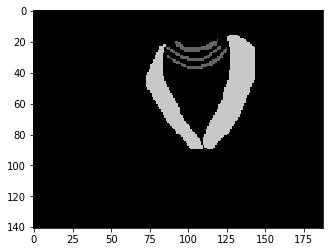

In [7]:
img_c = cv2.imread(str(get_image_files(path_img)[203]))
img = cv2.imread(str(get_image_files(path_lbl)[55]))
# img = resize(img, (500,500),anti_aliasing=True)

# fig=plt.figure(figsize=(8, 8))
# fig.add_subplot(1)

# plt.imshow(img*100)
# blur_img = cv2.blur(img, (3,3))
# plt.subplot(1,1)
plt.imshow(img*100)

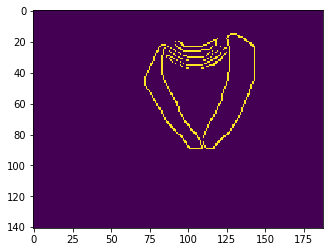

In [8]:
edges = cv2.Canny(img, 1,1)
plt.imshow(edges)

# Blob (Instance) Detection

In [9]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from scipy import ndimage

In [10]:
num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

In [11]:
# def get_blobs(img, imshow=False):
#     img2 = img_as_ubyte(np.array(img))
# #     print(img2.shape)

#     #each channel in sep_classes contains a given class of labels. sep_blobs[i].shape is (img.width,img.height,num_classes)
#     sep_classes = []
#     for i in range (0,num_classes):
#         sep_classes.append( np.array(img2 == i ).astype(np.uint) )
        

#     blobs_labels = [measure.label(blobs, background=0)[:,:,0] for blobs in sep_classes]

#     plt.figure(figsize=(9, 3.5))

#     if imshow:
#         for i in range(1,num_classes):
# #             plt.axis('off')
#             plt.subplot(130+i)
#             plt.imshow(blobs_labels[i]*100, cmap='nipy_spectral')
#             plt.title(str(i))

# #         plt.axis('off')
#         plt.tight_layout()
#         plt.show()
        
#     return blobs_labels

Let's find blobs on a video

In [12]:
import sys
from fastai.vision import *
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output
import time

In [13]:
################################################
learn = None
cap = None
out = None

path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()
################################################
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str);
bs = 4

src = (SegmentationItemList.from_folder(path_img)
        .split_by_fname_file('../../valid.txt')
        .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet101);
learn.load('stage-2-big-0614-rn101');
################################################

In [14]:
# def crop_img(img,cropx,cropy):
#     cropx=np.min(img.shape[:2])
#     cropy=cropx
#     y,x = img.shape[:2]
#     startx = x//2-(cropx//2)
#     starty = y//2-(cropy//2)    
#     return resize(img[starty:starty+cropy,startx:startx+cropx], (224,224),anti_aliasing=True) #dtype = float64
# ################################################
# def mask_to_colour(mask,colour=[0,255,0]):
#     output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
#     green = [0,255,0]
#     red = [255,0,0]
#     blue = [0,0,255]
#     other = [150,200,0]
#     output_mask[mask==1]=red
#     output_mask[mask==2]=green
#     output_mask[mask==3]=blue
#     return output_mask

# #Swaps the r and b channels, for converting between PIL Image and Opencv BGR nparray
# def red_blue_swap(img):
#     return img[:, :, ::-1]
# ################################################

In [15]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
# out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/data/videos/output_polar_blobs.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (224,224))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
frame_timeline = []
eroded_timeline = []
###ENDOF PARAMS###

Cap fps: 29.97002997002997


In [16]:
#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
    
clear_output()
print ("Starting!")
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print(ctr)
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break

            
    #Convert from OpenCV image to pytorch tensor, to Image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #frame_rgb is uint8
    
    t = PIL.Image.fromarray(frame_rgb)
    t = pil2tensor(t.convert("RGB"), np.float32).div_(255)
    t = Image(t)
    
    #Predict
    prediction = learn.predict(t)
    p = prediction[1] #prediction data
    p1 = np.array(p)
    p1.astype('uint8')

    p3 = p1
    p3 = p3.squeeze()
    
    p4 = np.expand_dims(p3, axis=2)
    p4 = p4.astype('uint8')
    
    mask = np.copy(p4)
    mask=mask.squeeze()

    mask_d = mask_to_colour(mask)
    mask_d = img_as_float(mask_d)
    
    mask_timeline.append(mask)
#     plt.imshow(mask_d)
#     plt.show()
    
    ########################## NEW STUFF #################################
    img = mask.copy()
    img = img.astype(np.float32)

    #img.shape[0]/2, img.shape[1]/2
    #360,350
    
    ####### Find centroid of bifurcation#####
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    labels = get_blobs(mask,imshow=False)
    thresh = labels[3]
    thresh = img_as_uint(thresh*100)

    if len(np.where( thresh > 0 )[0]):
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 125
        cY = 150
        
    ###### endof find centre ############
    


    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
    polar_image = polar_image.astype(np.uint8)

    # plot_many([_,mask_timeline[71],polar_image])
#     plot_many([_,img,polar_image])
    e_list = []
    for num in range(5,12):
        e = cv2.erode(polar_image,np.ones((num,1)))
        e_list.append(e)
    eroded_timeline.append(e_list)
#     e = cv2.erode(e,np.ones((2,2)))

    e = cv2.erode(polar_image,np.ones((11,1)))
    clean_flattened_timeline.append((e,(cX,cY)))
#     plt.imshow(e)
#     plt.show()
    linear_image = cv2.linearPolar(clean_flattened_timeline[-1][0],(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    clean_timeline.append(linear_image)
    
    frame_rgb =crop_img(frame_rgb)
    frame_rgb = cv2.linearPolar(frame_rgb,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
#     frame_rgb = frame_rgb.astype(np.uint8)
    frame_timeline.append(frame_rgb)
    
    print(ctr)
    clear_output(wait=True)
#     plt.imshow(frame_rgb)
#     plt.show()
    
#     plt.imshow(linear_image)
#     plt.show()
    
#     cr=crop_img(frame,224,224) #cr is float64
    
#     #Save the overlaid frame
#     ov=overlay_mask(cr, mask_d)
    
#     # Write uint8 version of ov to output video
#     print(e.shape)
#     plt.imshow(e)
#     out.write(cv2.cvtColor(e*100, cv2.COLOR_GRAY2BGR))
    
cap.release()
# out.release()
print ("End!")

End!


<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

shape (4, 224, 224)


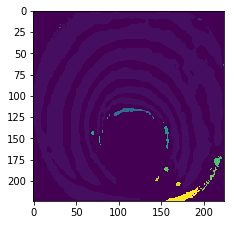

In [17]:
mask = cv2.cvtColor(mask_timeline[72],cv2.COLOR_GRAY2BGR)
labels = get_blobs(mask,imshow=False)
plt.imshow(labels[1])
print("shape {}".format(np.shape(labels)))

In [18]:
# out.release()

# Tracking

In [19]:
# plt.imshow(clean_flattened_timeline[71][0]==1)
# clean_flattened_timeline[71][0].shape

In [20]:
# import imutils

# def plot_many(images):
#     plt.figure(figsize=(9, 3.5))

    
#     for i in range(1,len(images)):
# #             plt.axis('off')
#         plt.subplot(130+i)
#         plt.imshow(images[i], cmap='nipy_spectral')
#         plt.title(str(i))

# #         plt.axis('off')
#     plt.tight_layout()
#     plt.show()


# def sort_contours(cnts, method="left-to-right"):
#     # initialize the reverse flag and sort index
#     reverse = False
#     i = 0

#     # handle if we need to sort in reverse
#     if method == "right-to-left" or method == "bottom-to-top":
#         reverse = True

#     # handle if we are sorting against the y-coordinate rather than
#     # the x-coordinate of the bounding box
#     if method == "top-to-bottom" or method == "bottom-to-top":
#         i = 1

#     # construct the list of bounding boxes and sort them from top to
#     # bottom
#     boundingBoxes = [cv2.boundingRect(c) for c in cnts]
#     (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][i], reverse=reverse))

#     # return the list of sorted contours and bounding boxes
#     return (cnts, boundingBoxes)



# def draw_contour(image, c,bbox, i):
#     # compute the center of the contour area and draw a circle
#     # representing the center
# #     M = cv2.moments(c)
# #     cX = int(M["m10"] / M["m00"])
# #     cY = int(M["m01"] / M["m00"])
#     x,y,w,h = bbox
#     cX = x+25#+w/2.0
#     cY = y+10#+h/2.0
    
#     # draw the countour number on the image
#     cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
#         0.3, (255, 255, 255), 1)

#     # return the image with the contour number drawn on it
#     return image

In [21]:
# def contiguous_regions(condition):
#     """Finds contiguous True regions of the boolean array "condition". Returns
#     a 2D array where the first column is the start index of the region and the
#     second column is the end index."""

#     # Find the indicies of changes in "condition"
#     d = np.diff(condition)
#     idx, = d.nonzero() 

#     # We need to start things after the change in "condition". Therefore, 
#     # we'll shift the index by 1 to the right.
#     idx += 1

#     if condition[0]:
#         # If the start of condition is True prepend a 0
#         idx = np.r_[0, idx]

#     if condition[-1]:
#         # If the end of condition is True, append the length of the array
#         idx = np.r_[idx, condition.size] # Edit

#     # Reshape the result into two columns
#     idx.shape = (-1,2)
#     return idx

# def longest_contiguous_region(condition):
#     region = (0,0) # (start,stop)
#     longest = (0,0)
#     for start, stop in contiguous_regions(condition):
#         segment = histogram[start:stop]
#         if len(segment) > longest[1]-longest[0]:
#             region = (start,stop)
#     #     print start, stop
#     #     print segment.min(), segment.max()
#     centrepoint = int((region[0]+region[1])/2)
#     return region, centrepoint

# def pltimg(img):
#     plt.imshow(img)
#     plt.show()

### Let's try using a vertical histogram to track the features

In [22]:
# # plt.imshow(np.expand_dims(histogram, axis=0))

# histogram_v = np.sum((mask==1).astype(np.uint8), axis=0)#row-wise sums

# hist_img = np.expand_dims(histogram_v, axis=0)
# print(hist_img.shape)
# hist_img = resize(hist_img,(224, 224),anti_aliasing=True)
# print(hist_img.shape)

# # resize(img, (500,500),anti_aliasing=True)
# print(hist_img.dtype, img_as_float(mask).dtype)
# plot_many([_,hist_img,img_as_float(mask)])

# # Print the start and stop indicies of each region where the absolute 
# # values of x are below 1, and the min and max of each of these regions


## Tests with watershed

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import ndimage as ndi

# from skimage.morphology import watershed
# from skimage.feature import peak_local_max

# mask = mask_continuous_timeline[0]
# img_og = mask
# image = ((mask==1)*100).copy()
# image = image.astype(np.uint8)

# # pltimg(image)
# # print("original")

# kernel = np.ones((3,3),np.uint8)
# image = cv2.dilate(image, kernel)
# opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = 1)
# # pltimg(opening)

# # print("opening")

# image = cv2.erode(image, kernel)
# image = cv2.dilate(image, kernel)

# image = cv2.blur(image,(5,5))
# # pltimg(image)

# ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# pltimg(thresh)

# #thresh is super clean
# image = thresh

# #finding sure background
# sure_bg = cv2.dilate(image,kernel,iterations=3)
# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening,cv2.DIST_C,0)
# pltimg(cv2.blur(dist_transform,(3,3)))
# ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)
# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)


# fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
# ax[0].set_title('sure_bg')
# ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
# ax[1].set_title('sure_fg')
# ax[2].imshow(unknown, cmap=plt.cm.nipy_spectral, interpolation='nearest')
# ax[2].set_title('unknown')

# for a in ax:
#     a.set_axis_off()

# fig.tight_layout()
# plt.show()

In [24]:
# # Marker labelling
# ret, markers = cv2.connectedComponents(sure_fg)
# # Add one to all labels so that sure background is not 0, but 1
# markers = markers+1
# # Now, mark the region of unknown with zero
# markers[unknown==255] = 0
# pltimg(markers)

# i = cv2.cvtColor(img_og, cv2.COLOR_GRAY2BGR)
# markers = cv2.watershed(i,markers)
# output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
# output_mask[markers==-1] = [0,255,0]
# pltimg(markers)

In [25]:
# # Now we want to separate the two objects in image
# # Generate the markers as local maxima of the distance to the background
# distance = ndi.distance_transform_edt(image)
# local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
#                             labels=image)
# markers = ndi.label(local_maxi)[0]
# labels = watershed(-distance, markers, mask=image)
# print("Labels: {}".format(np.unique(labels)))
# # labels = labels==20

# fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
# ax[0].set_title('Overlapping objects')
# ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
# ax[1].set_title('Distances')
# ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
# ax[2].set_title('Separated objects')

# for a in ax:
#     a.set_axis_off()

# fig.tight_layout()
# plt.show()

## Finding the posterior region

In [26]:
mask_continuous_timeline = []

Posterior angle: 112 from 114
199


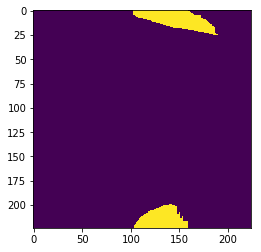

In [27]:
# tracker = cv2.MultiTracker_create()
area_thresh = 40
colors = [] 
colors.append((0,255,0))
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
# while True:
#   # draw bounding boxes over objects
#   # selectROI's default behaviour is to draw box starting from the center
#   # when fromCenter is set to false, you can draw box starting from top left corner
#   bbox = cv2.selectROI('MultiTracker', frame)
#   bboxes.append(bbox)
#   colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
#   print("Press q to quit selecting boxes and start tracking")
#   print("Press any other key to select next object")
#   k = cv2.waitKey(0) & 0xFF
#   if (k == 113):  # q is pressed
#     break

# bboxes = []
# im = np.zeros((224,224,3), np.uint8)

# _, contours, _ = cv2.findContours(clean_flattened_timeline[71]*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#RETR_LIST


###Remove this after
# c = contours[14]
# print("contours length: {}".format(contours))

# for c in contours:
##remove after
# c = contours[8]
# ##endof remove after

# rect = cv2.boundingRect(c)
# #     if rect[2] * rect[3] < 100: continue
# # print (cv2.contourArea(c))
# x,y,w,h = rect
# cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
# cv2.drawContours(im, [c], -1, (255,0, 0), 2)
# bboxes.append(rect)

# plt.imshow(im)
# plt.show()

##########contour sorting###########
# tracker = cv2.TrackerGOTURN_create()
# #Get first contours for a bbox
# cnts = cv2.findContours(clean_flattened_timeline[71][0]*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
# (cnts, boundingBoxes) = sort_contours(cnts)
# #endof get first contours for a bbox
# ret = tracker.init(frame_timeline[71],boundingBoxes[6])
# cloned = clean_flattened_timeline[71][0].copy()
# x,y,w,h =  boundingBoxes[8]
# cv2.rectangle(cloned,(x,y),(x+w,y+h),(0,255,0))
# plt.imshow(cloned)
# plt.show()
# time.sleep(3)

ctr = 0
###h
# prev_posterior_angles = [math.pi/2,math.pi/2,math.pi/2,math.pi/2]#circular buffer to calculate avg
prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]
for mask, frame in zip(clean_flattened_timeline[71:], frame_timeline[71:]):
    mask = mask[0]
    ctr+=1
#     cnts = cv2.findContours(mask*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     cnts = imutils.grab_contours(cnts)
#     cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # Keep only large contours
#     cnts_l = []
#     for c in cnts:
#         if cv2.contourArea(c)>area_thresh:
#             cnts_l.append(c)


#     orig = mask.copy()
#     orig*=10013
#     orig = frame.copy()
    
    # sort the contours according to the provided method
#     (cnts, boundingBoxes) = sort_contours(cnts)

    # loop over the (now sorted) contours and draw them
#     cv2.drawContours(orig, cnts, -1, (0, 255, 0), 2)
#     for (i, c) in enumerate(cnts):
#         draw_contour(orig,c,boundingBoxes[i], i)
#         if True:
# #             orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
#             x,y,w,h = boundingBoxes[i]
#             cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
        
    # Find anterior and posterior parts
    histogram = np.sum((mask==1).astype(np.uint8), axis=1)#row-wise sums
    region, posterior = longest_contiguous_region(histogram < 5, histogram)
#     print(posterior)#posterior is the row (i.e. angle in polar notation) of the centre of posterior region

    ###h
#     posterior_angle = posterior*(2*math.pi/mask.shape[0])
    posterior_angle = posterior
    prev_posterior_angles[ctr%len(prev_posterior_angles)]=posterior_angle
    ###h
#     posterior_angle = np.average(prev_posterior_angles)
    posterior = int(np.average(prev_posterior_angles))
    print("Posterior angle: {} from {}".format(posterior_angle,posterior))
    
    frame_copy = frame.copy()
    frame_copy = cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    centreX, centreY = frame.shape[0]/2.0, frame.shape[1]/2.0

    L1 = 75
    L2 = 100
#     posterior_angle *= -1
    p1 = np.round((centreX+L1*math.cos(posterior_angle),centreY+L1*math.sin(posterior_angle))).astype(np.int)
    p2 = np.round((centreX+L2*math.cos(posterior_angle),centreY+L2*math.sin(posterior_angle))).astype(np.int)
#     frame_copy = img_as_uint(frame_copy)
    cv2.arrowedLine(frame_copy, tuple(p1),tuple(p2), (255,0,0),3)
    
    temp = mask[0:posterior,0:]
    mask_continuous = np.concatenate((mask[posterior:,0:],temp))
    mask_continuous_timeline.append(mask_continuous)
#     plt.imshow(mask_continuous)
#     plt.show()

    
    #show the output image
    print(ctr)
    
#     plt.imshow(frame_copy)
#     plt.imshow(cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS))
#     plot_many([_,orig,cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)])
    if True:
        plt.imshow(mask_continuous)
        plt.show()
    time.sleep(1)
    clear_output(wait=True)
#####################

In [28]:
# fig=plt.figure(figsize=(24,24))
# columns = 3
# rows = 3

# # for c in range (71,100):
# for i in range(1, min(columns*rows +1, len(eroded_timeline[0])+1)):
#     img = eroded_timeline[c][i%7]
#     img = cv2.linearPolar(img_as_float(img),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# #     clear_output()
# plt.show()
# #     plt.imshow(cv2.linearPolar(img_as_float(mask),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS))

In [29]:
len(mask_continuous_timeline)
len(clean_flattened_timeline[71:])

199

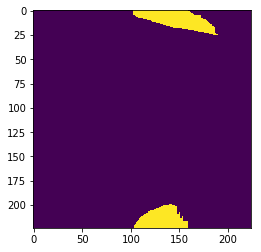

In [30]:
for frame in mask_continuous_timeline:
    clear_output(wait=True)
#     print(ctr)
    plt.imshow(frame)
    plt.show()

In [31]:
# mask_c = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
# plt.imshow(cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR))
# # plt.imshow(mask_c*100.0)

# mask_dilate = np.zeros_like(mask)
# mask_dilate = cv2.erode(mask,np.ones((3,3)))
# mask_dilate = cv2.dilate(mask_dilate,np.ones((5,5)))
# plt.imshow(mask_dilate)
# plt.show()

# # labels = get_blobs(mask_c,imshow=True)
# # one_ring = np.array(labels[1]==10)
# # plt.imshow(one_ring)
# # ndimage.measurements.center_of_mass(one_ring)

In [32]:
# img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
# print(np.unique(img))
# labels = get_blobs(img,imshow=True)

In [33]:
# plt.imshow(labels[3])

# thresh = labels[3]
 
# print(np.unique(thresh))
# thresh = img_as_uint(thresh*100)
# print(thresh)
# # convert the grayscale image to binary image
# # ret,thresh = cv2.threshold(gray_image,127,255,0)
 
# # calculate moments of binary image
# M = cv2.moments(thresh)
 
# # calculate x,y coordinate of center
# cX = int(M["m10"] / M["m00"])
# cY = int(M["m01"] / M["m00"])

# print((cX,cY))

In [34]:
# # targ = cv2.imread("/storage/vocal_cords_and_rings_data/data/target3.PNG")
# # plt.imshow(targ)

# ############################
# # img = targ
# img = mask_timeline[71]
# img = img.astype(np.float32)
# # img = cv2.resize(img,(240,190))

# #img.shape[0]/2, img.shape[1]/2
# #360,350

# # value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
# value = img.shape[0]/2.0
# polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
# polar_image = polar_image.astype(np.uint8)

# # plot_many([_,mask_timeline[71],polar_image])
# plot_many([_,img,polar_image])

In [35]:
# e = cv2.erode(polar_image,np.ones((11,1)))
# e = cv2.erode(e,np.ones((2,2)))

# plt.imshow(e)
# print(np.unique(e))

In [36]:
# linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
# plt.imshow(linear_image)
# print(np.unique(linear_image))
# print(linear_image[cX,cY])

In [37]:
# img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
# print(np.unique(img))
# labels = get_blobs(img,imshow=True)

# img = cv2.cvtColor(linear_image,cv2.COLOR_GRAY2BGR)
# print(np.unique(img))
# labels = get_blobs(img,imshow=True)

In [38]:
# # print(cv2.cvtColor(labels[1],cv2.COLOR_GRAY2BGR).shape)
# from imutils import perspective
# from imutils import contours
# import imutils

# # edged = cv2.Canny(img*100, 50, 100)
# # edged = cv2.dilate(edged, None, iterations=1)
# # edged = cv2.erode(edged, None, iterations=1)

# cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
 
# # sort the contours from left-to-right and initialize the
# # 'pixels per metric' calibration variable
# (cnts, _) = contours.sort_contours(cnts)


In [39]:
# large_cnts=[]
# for c in cnts:
#     if cv2.contourArea(c) > 30:
#         large_cnts.append(c)
# print(len(large_cnts))
# orig = np.zeros_like(img)
# cv2.drawContours(orig, [l for l in cnts], -1, (0, 255, 0), 2)
# plt.imshow(orig)
# # plot_many([cv2.drawContours(orig, l, -1, (0, 255, 0), 2) for l in cnts][:2])

## Skelletised to polar

In [40]:
# ## skel = cv2.imread('/storage/vocal_cords_and_rings_data/data/skelletised.png', cv2.IMREAD_GRAYSCALE)
# # plt.imshow(skel)
# polar_skel = cv2.linearPolar(skel,(cX,cY-20), value, cv2.WARP_FILL_OUTLIERS)
# polar_skel = cv2.threshold(cv2.blur(polar_skel,(1,3)),0,255,cv2.THRESH_BINARY)[1]
# plt.imshow(polar_skel)
# # plt.imshow()

In [41]:
# from skimage.morphology import skeletonize
# from skimage import data
# import matplotlib.pyplot as plt
# from skimage.util import invert

# # Invert the horse image
# iimage = np.array(blobs_new[3][0]>0)


# edges = cv2.Canny(iimage, 1,1)
# _, contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours_poly = cv2.approxPolyDP(contours, 3, True)
# boundRect = cv2.boundingRect(contours_poly)

# drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

# # # perform skeletonization
# # skeleton = skeletonize(iimage)


# pltimg(skeleton)

## Tracking from scratch

TODO: Implement blob wise intersection. The corresponding blobs in frame t+1 will be the one that the current blob has the largest intersection with.

Should really work. Try!

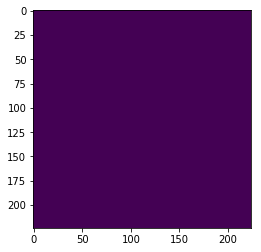

In [42]:
# Erode/dilate/blur/thresh ring mask to make the edges smooth, and attempt to eliminate unwanted connections between rings
clean_blobs = []
for mask in mask_continuous_timeline:   
    img_og = mask
    image = ((mask==1)*100).copy()
    image = image.astype(np.uint8)

    # pltimg(image)
    # print("original")

    kernel = np.ones((3,3),np.uint8)
    image = cv2.dilate(image, kernel)
    opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = 1)
    # pltimg(opening)

    # print("opening")

    image = cv2.erode(image, kernel)
    image = cv2.dilate(image, kernel)

    image = cv2.blur(image,(5,5))
    # pltimg(image)

    ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    pltimg(thresh)
    clear_output(wait=True)

    #thresh is super clean
    clean_blobs.append(thresh)

In [43]:
# '''
# returns a list in which each channel is an individual blob
# '''
# def get_blobs_single_class(img, label_value):
#     blobs = measure.label(np.array(img_as_ubyte(np.array(img)) == label_value).astype(np.uint) )
#     independent_blobs = []
#     for i in np.unique(blobs)[1:]:
#         single_blob = np.zeros_like(blobs)
#         single_blob[blobs==i]=255
#         independent_blobs.append(single_blob)
#     return independent_blobs

In [44]:
# def blob_area(bin_img):
#     return len(np.where(bin_img>0)[0])

def correlate_blobs(new_blobs, prev_blobs, percent_overlap_thresh=0.75, child_area_thresh=1.5, orphan_min_area=50):
    """
    Link parent blobs from prev_blobs to children blobs from new_blobs
    constraints:

    0) children can only have one parent. parents can have multiple children

    1) children must have a large enough intersection with their parent

    2) children must be smaller than their parents (they are allowed to be larger up to a certain threshold)
    if a potential child has a strong correlation to a given potential parent (large intersection), it is only
    considered a child if child_area < parent_area*thresh (where thresh is >= 1)
    else if a potential child has a strong correlation to a given potential parent, and it doesn't meet the area criteria,
    a new track is created for it and it is parentless (TODO: consider going "back" in the tree and grouping previous blobs
    and considering them as a single blob so that the area criteria is met. rn thinking not needed)

    Args:
        new_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in current 
                   frame (see get_blobs_single_class() )
        prev_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in previous
                   frame (see get_blobs_single_class() )
        percent_overlap_thresh (default: 0.75): minimum amount that
                   child must overlap with parent to be considered
                   a child
        child_area_thresh (default: 1.5): child can be up to
                   child_area_thresh times bigger than its parent
                   to be considered a child
        orphan_min_area (default: 50): minimum area for a parentless
                   blob to be added to orphan list. All orphans with
                   less than orphan_min_area will be disregarded
                   
    Returns:
        family, orphans
        
        family: list of tuples of (child_blob, parent_blob) i.e. the
                actual frames are tuple[0] and tuple[1]
                If a parent has no children, entry will be (zero_arr, parent_blob)
                len of family is num_parent_blob
                
        orphans: list of tuples of (orphan_blob, None) i.e. the actual
                frame is tuple[0], and tuple[1] is None
                len of orphans is the number of orphans in current frame
                   
    """
    parent_to_children = {} #key is the parent ID, value is the child ID
    orphans = [] # IDs of blobs without parents
    
    #Make all children empty lists
    for p in range(0, len(prev_blobs)):
        parent_to_children[p] = [] 
    
    #Populate parent_to_child dict (children pick their parents)
    for c in range(0, len(new_blobs)):
        nblob = new_blobs[c]
   
        max_intercept = 0
        max_intercept_p = -1
                        
        for p in range(0,len(prev_blobs)):
            pblob = prev_blobs[p]
            intersect = cv2.bitwise_and(nblob, pblob)
            
            if blob_area(intersect) > max_intercept:
                max_intercept = blob_area(intersect)
                max_intercept_p = p
          
        if max_intercept > 0 and blob_area(nblob) < blob_area(prev_blobs[max_intercept_p])*child_area_thresh and max_intercept > blob_area(nblob)*0.10:
            parent_to_children[max_intercept_p].append(c) #Huzzah! Child picked a parent
#             print("nparents {} -child {} picked {} ".format(len(prev_blobs), c, max_intercept_p))
        else: #Child has no parent
            orphans.append(c)
                    
    #Join children blobs (if they belong to the same parent) to deal with blob separation
    #and add (child,parent) tuple to a "family" list
#     joined_blobs = {} # len(new_blobs) == len(prev_blobs)+len(orphans)
    family = []
    
    for p in range (0, len(parent_to_children)):
#         joined_blobs[p] = []
        if len(parent_to_children[p])>1: #parent has more than one child
            joined_blob = np.zeros_like(prev_blobs[0])
            for child_blob_index in parent_to_children[p]:
                joined_blob = cv2.bitwise_or(new_blobs[child_blob_index], joined_blob)
#                 print("JOINED BLOB TYPE {}".format(joined_blob.dtype))
#                 print("joined_blobs shape: {}".format(joined_blob.shape))
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
            
        elif len(parent_to_children[p])==1:
            joined_blob = new_blobs[parent_to_children[p][0]]
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
        else: #do nothing -> i.e. a parent that didn't have a child will die
            family.append((np.zeros_like(prev_blobs[p]),prev_blobs[p]))
    
    #Add orphans to the future parents list, so they can have children
    orphan_imgs = []
    for o in orphans:
        if np.count_nonzero(new_blobs[o]) > orphan_min_area:
            orphan_imgs.append((new_blobs[o], None))
        
    
    return family, orphan_imgs #joined_blobs has prev_parents+orphans number of channels, each channel being an individual blob

In [45]:
# pltimg(mid_new[6])
# pltimg(mid_prev[6])
# print(len(np.unique(mid_new[6])))
# print(len(np.unique(mid_prev[6])))
# n, o = correlate_blobs([mid_new[6]], [mid_prev[6]])

In [46]:
# np.shape(n)
# pltimg(n[1][1])

In [47]:
# def collapse_all_channels(blobs_new):
#     blobs_new_frame = np.zeros_like(blobs_new[0][0])
# #     print(np.shape(blobs_new_frame))
#     for b in blobs_new:
# #         print("b {}".format(np.shape(b)))
#         blobs_new_frame = np.array(blobs_new_frame) | np.array(b[0])
#     return blobs_new_frame

In [48]:
# pltimg(collapse_all_channels( clean_blobs[0:4] ))

In [49]:
# slope=1
# weight_fn = lambda x: slope*x+1

# def avg_frames(frames):
#     #most current frame must be last
#     blank_frame = np.zeros_like(frames[0])
#     for (i, f) in enumerate(frames):

#         blank_frame += np.array(f==1).astype(np.uint8)*weight_fn(i)
    
#     blank_frame = blank_frame/np.max(blank_frame)
#     blank_frame = blank_frame>0.75

#     return blank_frame

In [50]:
# pltimg(blobs_new[0][0])
# pltimg(blobs_new[0][1])

# def plot_blob_generations(blobs_new, orphans, include_orphans=True, frame=None):

#     colours = np.linspace(10,249,40).astype(np.uint8)


#     overlayed_children = np.zeros_like(blobs_new[0][0])
#     overlayed_parents = np.zeros_like(blobs_new[0][0])


#     if frame is None:
#         fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
#     else:
#         fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
#     ax = axes.ravel()

#     for (i,b) in enumerate(blobs_new):
#         colour = random.randint(10,255)
#         if len(np.unique(b[0])) > 0 :
#             overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colour).astype(np.uint8)
#         if len(np.unique(b[1])) > 0:
#             overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colour).astype(np.uint8)
    
    
    
#     if (include_orphans):
# #         print("this one has orphans")
#         overlayed_orphans = np.zeros_like(blobs_new[0][0])
#         for (i,b) in enumerate(orphans):
# #             print("orphan {}: {}".format(i, np.unique(b[0])))
#             overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*255).astype(np.uint8)
#             overlayed_orphans = (overlayed_orphans) | (b[0]/np.max(b[0])*255).astype(np.uint8)
# #             print('orphan img')
#         ax[2].imshow(overlayed_orphans, cmap='nipy_spectral', vmin=0, vmax=255)
#         ax[2].set_title('orphans')
# #             overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colours[i]).astype(np.uint8)

#     ax[0].imshow(overlayed_children, cmap='nipy_spectral', vmin=0, vmax=255)
#     ax[0].set_title('child')
#     ax[1].imshow(overlayed_parents, cmap='nipy_spectral', vmin=0, vmax=255)
#     ax[1].set_title('parent')
    
#     if frame is not None:
#         ax[3].imshow(frame)
#         ax[3].set_title('raw frame')
    
#     fig.tight_layout()
#     plt.show()
    
#     return overlayed_children


In [51]:
# def plot_blobs_in_order(blobs_in_frame):

#     colour = np.linspace(10,249,40).astype(np.uint8)


# #     if frame is None:
# #         fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
# #     else:
# #         fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
# #     ax = axes.ravel()

#     output_frame = np.zeros_like(blobs_in_frame[0])
#     for (i,b) in enumerate(blobs_in_frame):
#         output_frame = (output_frame) | (b/np.max(b)*colour[i]).astype(np.uint8)
        
# #     print("from plot_blobs_in_order:")
# #     pltimg(output_frame)
#     return output_frame

In [52]:
# def get_middle_section(blobs):
#     overlayed_children = np.zeros_like(blobs[0][112:122,:])
#     cnt = 0
#     for (i,b) in enumerate(blobs):
#         blob = b[112:122,:]
#         if len(np.unique(blob)) > 1:
#             cnt+=1
#             overlayed_children = (overlayed_children) | (blob/np.max(blob)*(cnt)).astype(np.uint8)
# #     print(np.unique(overlayed_children))
#     return overlayed_children

In [53]:
# '''
# Orders blobs that are in the middle section from right to left, and returns a
# list of tuples of (blob's unique value, centroid x position)
# '''
# def sort_right_to_left(mid_sec):
#     mid_blob_vals = []
    
#     for u in np.unique(mid_sec)[1:]:
#         M = cv2.moments((mid_sec==u).astype(np.uint8))
#         cX = int(M["m10"] / M["m00"])
#         mid_blob_vals.append((u,cX))
        
#     mid_blob_vals.sort(key=lambda tup: tup[1], reverse=True) 
#     return mid_blob_vals


# # def blob_in_list(blob, l):
# #     if blob is not None:
# #         for i,b in enumerate(l):
# #             if len( np.unique((blob)&(b)) )>1:
# #                 return True, i
# #     return False, -1

# def blobs_intersect(b1, b2):
#     if b1.shape != b2.shape: raise Exception('blob shapes {} and {} do not match'.format(b1.shape, b2.shape))
#     return len( np.unique((b1)&(b2)) )>1

In [48]:
# mask_continuous_timeline[0]

[(1, 213), (3, 176), (2, 142), (5, 110), (6, 86), (4, 66), (7, 53)]


/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:404: RuntimeWarning: invalid value encountered in true_divide
  overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colour).astype(np.uint8)


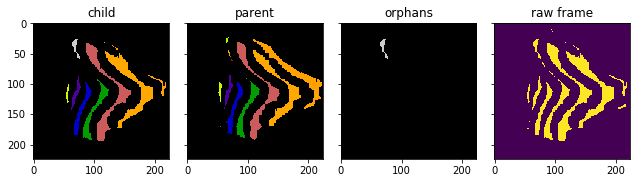

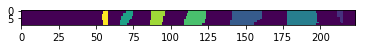

(224, 224)
(224, 224)


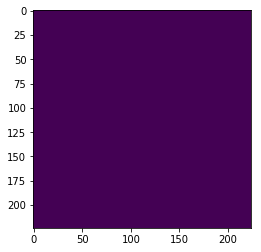

(224, 224)
(224, 224)


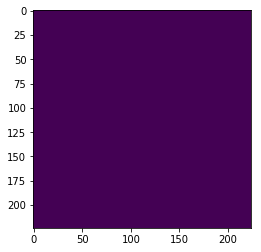

(224, 224)
(224, 224)


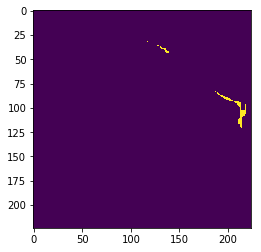

(224, 224)
(224, 224)


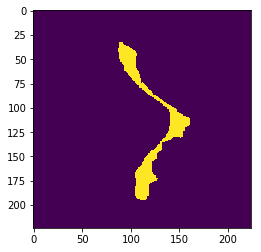

(224, 224)
(224, 224)


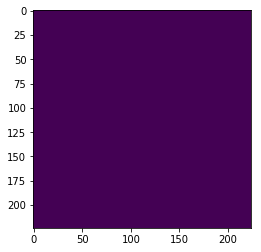

(224, 224)
(224, 224)


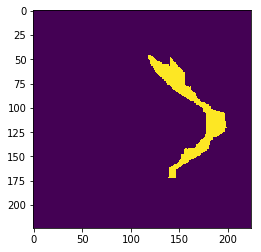

(224, 224)
(224, 224)


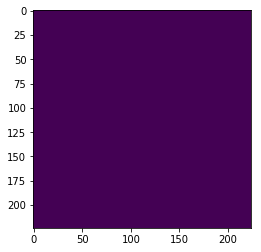

(224, 224)
(224, 224)


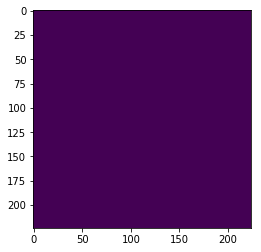

(224, 224)
(224, 224)


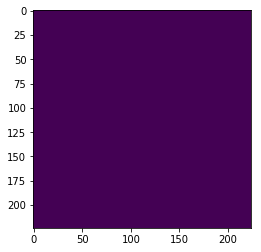

(224, 224)
(224, 224)


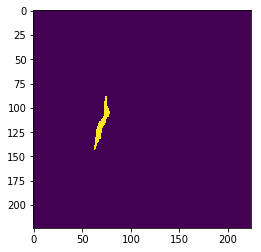

(224, 224)
(224, 224)


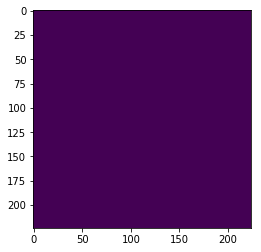

(224, 224)
(224, 224)


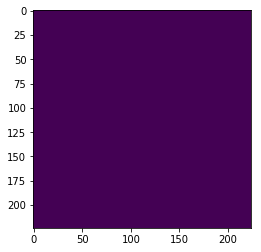

(224, 224)
(224, 224)


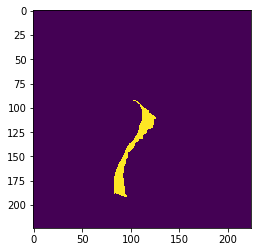

(224, 224)
(224, 224)


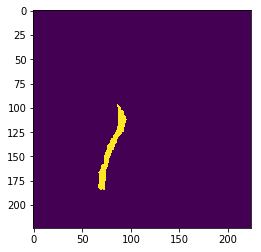

(224, 224)
(224, 224)


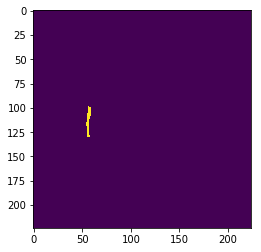

(224, 224)
(224, 224)


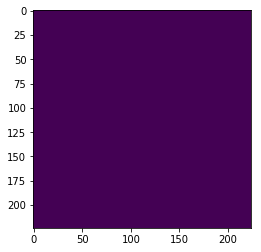

(224, 224)
(224, 224)


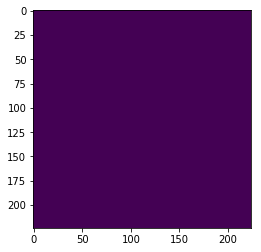

/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:455: RuntimeWarning: invalid value encountered in true_divide
  output_frame = (output_frame) | (b/np.max(b)*colour[i]).astype(np.uint8)


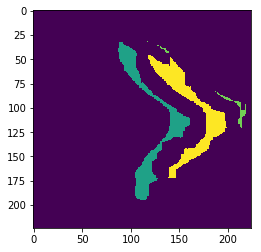

IndexError: too many indices for array

In [49]:
## TEST ONE!!!

verbose = False
# prev_frame = avg_frames([mask_continuous_timeline[2],mask_continuous_timeline[1],mask_continuous_timeline[0]])
# prev_frame = clean_blobs[0]==255
# pltimg(prev_frame)


###INIT FOR FIRST FRAME
prev_frame = mask_continuous_timeline[0]==1
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)

blobs_in_frame = []
mid_sec = get_middle_section(blobs_prev)
mid_blob_vals = sort_right_to_left(mid_sec)
print(mid_blob_vals)

for v in mid_blob_vals:
    blob = (mid_sec==v[0]).astype(np.uint8)
    for b in blobs_prev:
        if blobs_intersect(blob, b[112:122,:]):
            blobs_in_frame.append(b)
    
# print(blobs_in_frame)

cnt = 0
# for img in clean_blobs:
for (i, img) in enumerate(mask_continuous_timeline[2:]):
    img = img==1

    #Attempt at averaging stuff
#     img = avg_frames([mask_continuous_timeline[i-2],mask_continuous_timeline[i-1],mask_continuous_timeline[i]])
#     pltimg(img)
#     pltimg(prev_frame)

#     clear_output(wait=True)
#     print("counter: {}".format(cnt))
    cnt +=1
    
    #Find all blobs in current frame
    blobs_current = get_blobs_single_class(img, label_value=255)
        
#     blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
    
    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(blobs_current, blobs_prev)
    
    if blobs_new is None:
        print("EMPTY!!")

    #Add orphans to blobs_prev, so they can become parents in the next iteration
    #Note: this happens AFTER children have already found their parents
    blobs_prev = [blob_[0] for blob_ in blobs_new]
    orphan_imgs = [np.array(o[0]).astype(np.int32) for o in orphans]
    blobs_prev = blobs_prev+orphan_imgs
    
#     pltimg(img)
    plot_blob_generations(blobs_new, orphans, include_orphans=True, frame=img)
    
    
    ####### Let's assign order to the blobs
    
#     blob_ID_dict = {} #Maps unique ID to blob frame
#     IDs = 0
#     for blob in blobs_new:
#         blob_ID_dict[IDs]=blob
#         IDs += 1
    
    #count the middle ones
    blob_order_new = []
    
    children_blobs = [blob_[0] for blob_ in blobs_new]
    num_children_blobs=np.unique(children_blobs)[-1]
    children_blobs.extend([(blob_[0]/np.max(blob_[0])*(i+1+num_children_blobs)).astype(np.uint8) for i, blob_ in enumerate(orphans)])
    children_blobs = np.array(children_blobs)
    mid_sec = get_middle_section(children_blobs)
    
    pltimg(mid_sec)
    
    mid_blob_vals = sort_right_to_left(mid_sec)
    
#     plot_blobs_in_order(children_blobs)
    for b in children_blobs:
        print(b.shape)
        print(np.squeeze(b).shape)
        pltimg(np.squeeze(b))
    
    #Arrange children blobs in sorted order
    children_blobs = children_blobs[[val[0] for val in mid_blob_vals]]
    
    plot_blobs_in_order(children_blobs)
    
    #match to "children" blobs
    #STEPS A, B, C
#     for val in mid_blob_vals:
#         mid_blob = (mid_sec==val[1]).astype(np.uint8)
#         if blobs_intersect(mid_blob, b[0][112:122,:]):
# #             blobs_in_frame_new.append(b[0])
#             blob_order_new.append((b[0], -1))

    #STEP D, E
    #find parent of blobs in blob_order_new
    #Currently does not include orphans
    for i, blob_o_n in enumerate(blob_order_new):
        for child, parent in blobs_new:
            if blobs_intersect(blob_o_n[0], child):
                #now match parent to the frame in blob_order_prev
                for j, blob_o_p in enumerate(blob_order_prev):
                    if blobs_intersect(parent, blob_o_p[0]):
                        blob_order_new[i][1] = blob_o_p[j][1] #set order num to prev order num
    
    #Now deal with the ones that did not match
#     for i, blob_o_n in enumerate(blob_order_new):
#         if blob_o_n[1] == -1:
            #Case 1
            ###must first include orphans as part of the order_new and order_prev lists
            #Case 3
            #TODO: Handle orphan in between 2 existing blobs (Case 2)
                
        
    
    
    
    
    
    #see if "parent" blob was in previous frame
    mid_sec_prev = get_middle_section([blob_[1] for blob_ in blobs_new])
    mid_blob_vals_prev = sort_right_to_left(mid_sec_prev)
    prev_rightmost_parent = []
    for i, val in enumerate(mid_blob_vals_prev):
        mid_blob_prev = (mid_sec_prev==val[1]).astype(np.uint8)
        if blobs_intersect(mid_blob_prev, b[1][112:122,:]): #parent was in prev frame
            prev_rightmost_parent = b1
       
    for b in blobs_new:
        if blobs_intersect(blobs_in_frame[0],b[0]):
            #parent of rightmost current blob is not the rightmost blob from the previous frame
            # i.e. the previous rightmost one left
            if not blobs_intersect(b[1], prev_rightmost_parent):
                blobs_in_frame_new = [None] + blobs_in_frame_new
    
    
#     for b in blobs_new:
#         if blob_in_list(b[1], blobs_in_frame)
    
    
#     for bif in blobs_in_frame:
#         for b in blobs_new:
#             if blobs_intersect(bif, b[1]): #if parent is in the list
#                 blobs_in_frame[]
    
    
#     #Add all blobs in blobs_new to blobs_in_frame list, at the right index
#     for b in blobs_new:
#         ret, idx = blob_in_list(b[1], blobs_in_frame) #if parent was also in the past current frame (child blob has a parent)
#         if ret:
#             blobs_in_frame[idx]=b[0] #add child to ordered list blobs_in_frame
            
#         else: #add the "new" blobs to either the left of the right of the list
#             mid_sec = get_middle_section([blob_[0] for blob_ in blobs_new])
#             mid_blob_vals = sort_right_to_left(mid_sec)
            
#             for i, val in enumerate(mid_blob_vals):
#                 mid_blob = (mid_sec==val[1]).astype(np.uint8)
#                 if blobs_intersect(mid_blob, b[0][112:122,:]):
#                     if i == 0: #this new blob is coming in from the RHS (must give it lower index)
#                         blobs_in_frame = [b[0]]+blobs_in_frame
#                     elif i == len(mid_blob_vals)-1:#this new blob is coming in from the LHS (must give it higher index)
#                         blobs_in_frame = blobs_in_frame+[b[0]]
#                     else: #the blob appeared in between 2 blobs
#                         print("Case not dealt with.") #TODO: Deal with this case later
    
                    
    #Just for debugging
    mid_sec = get_middle_section([blob_[0] for blob_ in blobs_new])
    mid_blob_vals = sort_right_to_left(mid_sec)
    pltimg(mid_sec)
    print(mid_blob_vals)

    print("Printing in order - cnt= {}".format(cnt))
    pltimg(plot_blobs_in_order(blobs_in_frame_new))
        
    
    ###################################
#     mid_sec = get_middle_section([blob_[0] for blob_ in blobs_new])
    
#     pltimg(mid_sec)
#     mid_blobs=[]
#     for u in np.unique(mid_sec)[1:]:
# #         np.where( thresh > 0 )[0]
#         M = cv2.moments((mid_sec==u).astype(np.uint8))
#         # calculate x coordinate of center
#         cX = int(M["m10"] / M["m00"])
#         mid_blobs.append((u,cX))
        
#         #Find which "child blob" the partial mid_blob corresponds to
#         for full_blob in blobs_new:
#             blob = full_blob[0]
# #             if len(np.unique(((mid_sec==u).astype(np.uint8)) | (blob[112:122,:]))>1:
#                    blobs_in_frame[(mid_blobs.index(blob),)]
    ###################################
    
    prev_frame = img
    
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
    print(cnt)
#     time.sleep(0.5)
    
    

In [144]:
def collapse_channels(blobs):
    """
    Collapses all image channels into a single frame

    Reverses get_blobs_single_class

    Args:
        blobs: multi-channel image
    Returns:
        all blobs in a single frame
    """
    blobs_new_frame = np.zeros_like(blobs[0])

    for b in blobs:
        blobs_new_frame = np.array(blobs_new_frame) | np.array(b)
    return blobs_new_frame

def get_centroid_x(o):
    if blob_area(o)>0:
        M = cv2.moments((o>0).astype(np.uint8))
        cX = int(M["m10"] / M["m00"])
        return cX
    
def get_non_None_section(last_values):
    start_none = 0
    end_none = len(last_values)-1
    for j, val in enumerate(last_values):
        if val is not None:
            start_none=j
            break
            
    for j, val in enumerate(reversed(last_values)):
        ctr=len(last_values)-1-j
        if val is not None and ctr >= start_none:
            end_none=ctr
            break
    return start_none, end_none

area > 0
area > 0
area > 0
area > 0
area > 0
area > 0
area > 0
mid_new length: 7
middle sections collapsed (debug):


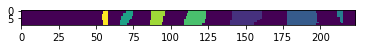

ORPHAN LEN 0, FAM LEN 7
counter 0


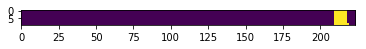

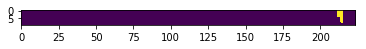

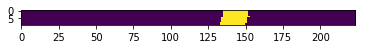

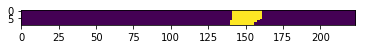

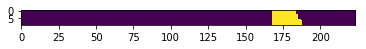

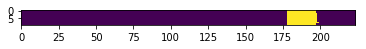

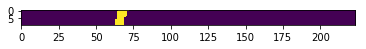

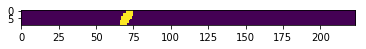

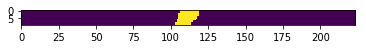

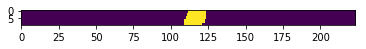

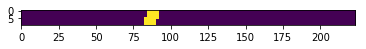

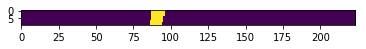

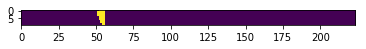

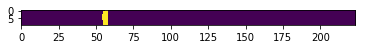

[[213, 212], [176, 187], [142, 149], [110, 116], [86, 90], [66, 70], [53, 55]]


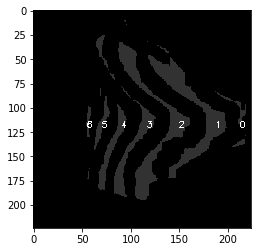

mid_new length: 7
middle sections collapsed (debug):


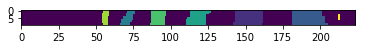

ORPHAN LEN 0, FAM LEN 7
counter 1


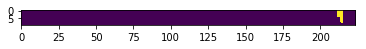

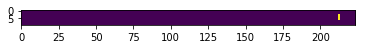

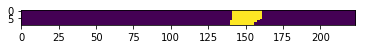

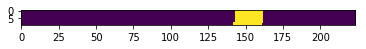

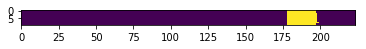

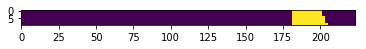

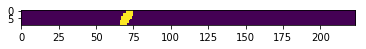

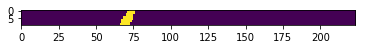

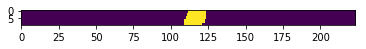

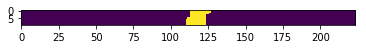

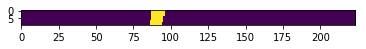

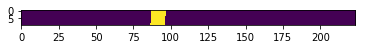

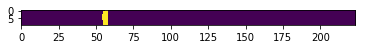

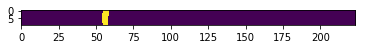

[[213, 212, 212], [176, 187, 191], [142, 149, 151], [110, 116, 117], [86, 90, 91], [66, 70, 71], [53, 55, 55]]


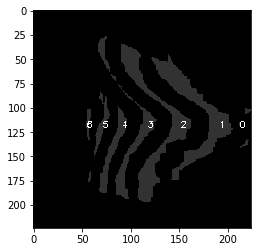

mid_new length: 6
middle sections collapsed (debug):


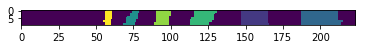

ORPHAN LEN 0, FAM LEN 7
counter 2


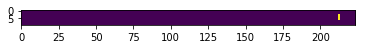

0 NO CHILD!!!


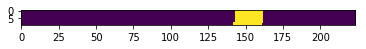

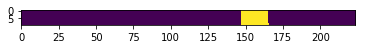

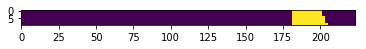

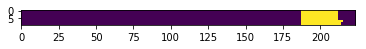

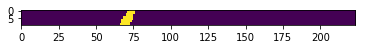

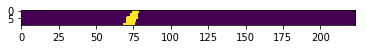

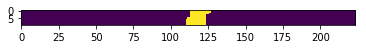

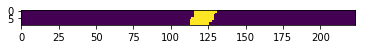

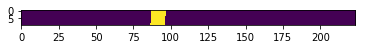

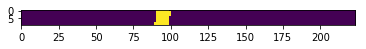

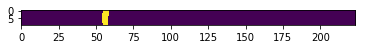

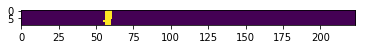

[[213, 212, 212, None], [176, 187, 191, 199], [142, 149, 151, 155], [110, 116, 117, 121], [86, 90, 91, 94], [66, 70, 71, 73], [53, 55, 55, 57]]


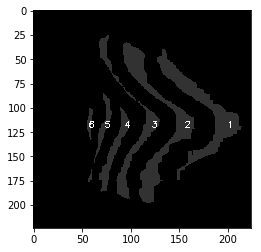

mid_new length: 6
middle sections collapsed (debug):


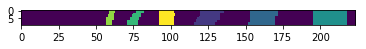

ORPHAN LEN 0, FAM LEN 6
counter 3


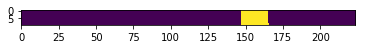

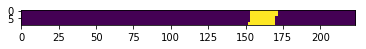

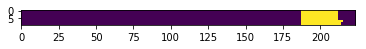

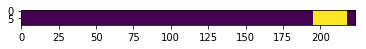

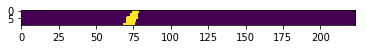

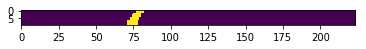

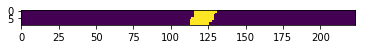

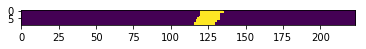

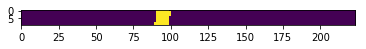

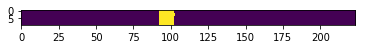

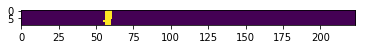

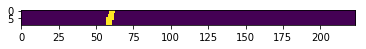

[[213, 212, 212, None], [176, 187, 191, 199, 206], [142, 149, 151, 155, 161], [110, 116, 117, 121, 125], [86, 90, 91, 94, 96], [66, 70, 71, 73, 75], [53, 55, 55, 57, 59]]


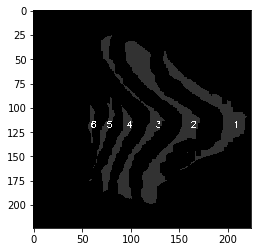

mid_new length: 6
middle sections collapsed (debug):


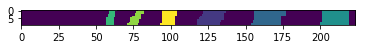

ORPHAN LEN 0, FAM LEN 6
counter 4


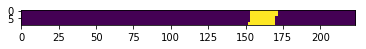

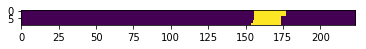

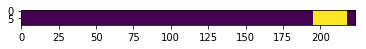

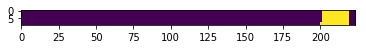

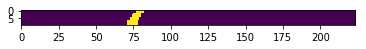

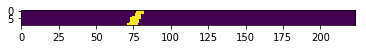

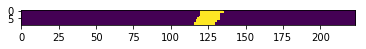

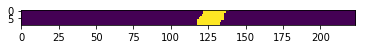

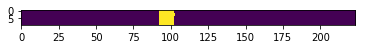

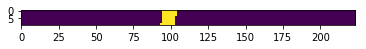

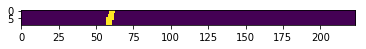

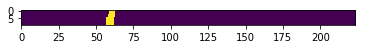

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209], [142, 149, 151, 155, 161, 164], [110, 116, 117, 121, 125, 127], [86, 90, 91, 94, 96, 98], [66, 70, 71, 73, 75, 76], [53, 55, 55, 57, 59, 59]]


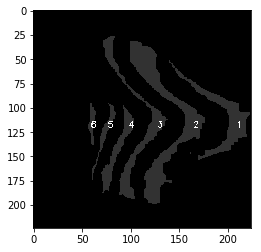

mid_new length: 7
middle sections collapsed (debug):


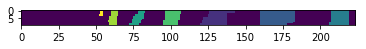

ORPHAN LEN 0, FAM LEN 6
counter 5


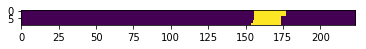

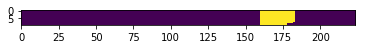

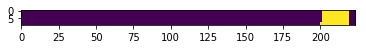

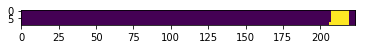

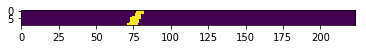

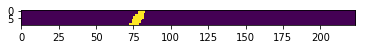

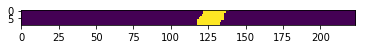

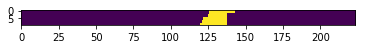

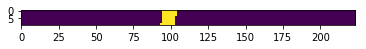

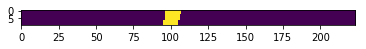

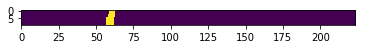

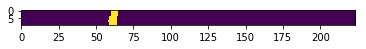

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212], [142, 149, 151, 155, 161, 164, 170], [110, 116, 117, 121, 125, 127, 130], [86, 90, 91, 94, 96, 98, 100], [66, 70, 71, 73, 75, 76, 77], [53, 55, 55, 57, 59, 59, 61]]


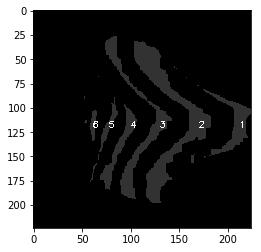

mid_new length: 7
middle sections collapsed (debug):


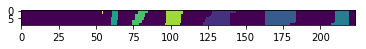

ORPHAN LEN 0, FAM LEN 6
counter 6


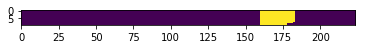

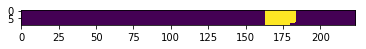

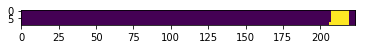

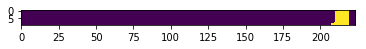

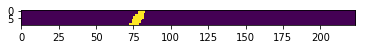

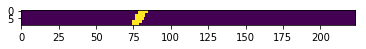

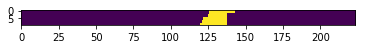

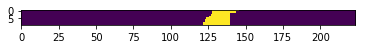

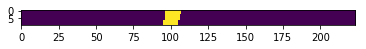

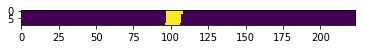

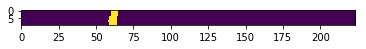

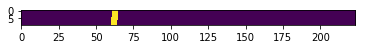

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213], [142, 149, 151, 155, 161, 164, 170, 172], [110, 116, 117, 121, 125, 127, 130, 132], [86, 90, 91, 94, 96, 98, 100, 101], [66, 70, 71, 73, 75, 76, 77, 78], [53, 55, 55, 57, 59, 59, 61, 62]]


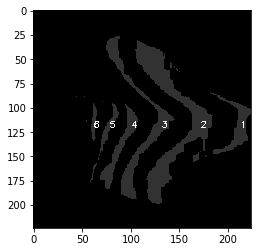

mid_new length: 6
middle sections collapsed (debug):


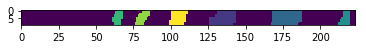

ORPHAN LEN 0, FAM LEN 6
counter 7


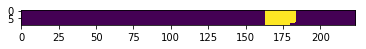

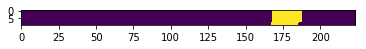

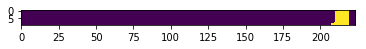

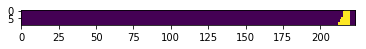

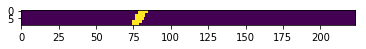

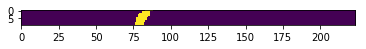

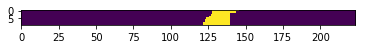

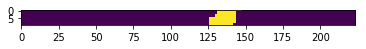

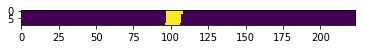

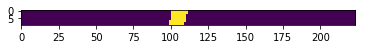

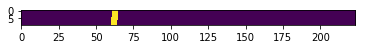

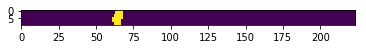

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216], [142, 149, 151, 155, 161, 164, 170, 172, 177], [110, 116, 117, 121, 125, 127, 130, 132, 135], [86, 90, 91, 94, 96, 98, 100, 101, 104], [66, 70, 71, 73, 75, 76, 77, 78, 80], [53, 55, 55, 57, 59, 59, 61, 62, 64]]


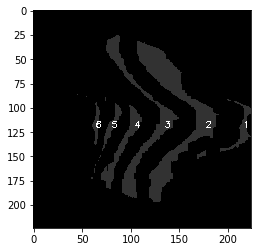

mid_new length: 6
middle sections collapsed (debug):


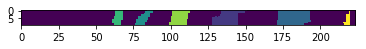

ORPHAN LEN 0, FAM LEN 6
counter 8


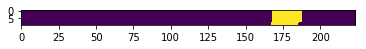

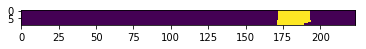

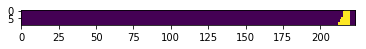

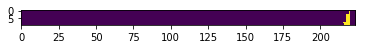

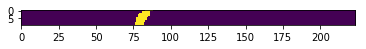

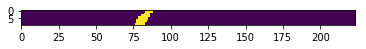

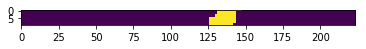

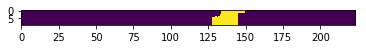

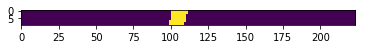

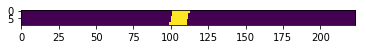

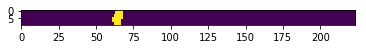

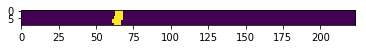

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64]]


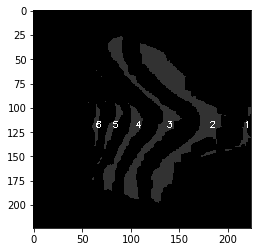

mid_new length: 5
middle sections collapsed (debug):


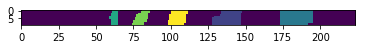

ORPHAN LEN 0, FAM LEN 6
counter 9


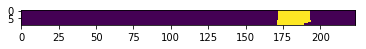

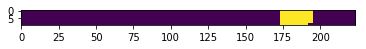

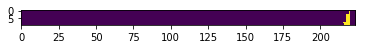

1 NO CHILD!!!


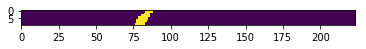

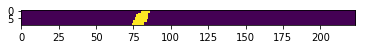

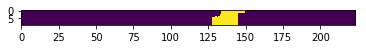

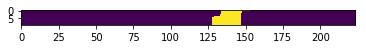

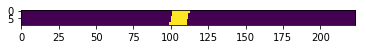

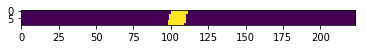

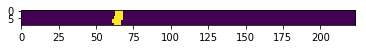

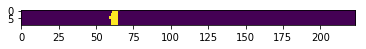

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62]]


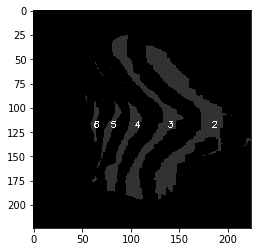

mid_new length: 5
middle sections collapsed (debug):


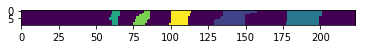

ORPHAN LEN 0, FAM LEN 5
counter 10


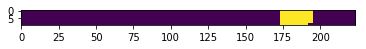

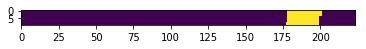

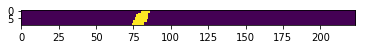

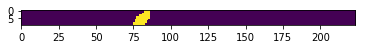

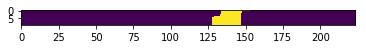

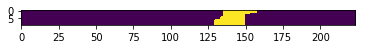

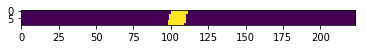

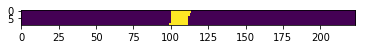

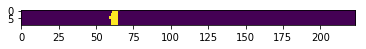

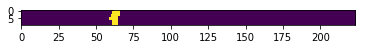

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62]]


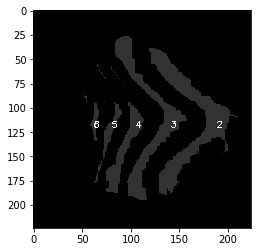

mid_new length: 5
middle sections collapsed (debug):


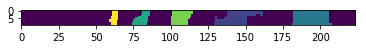

ORPHAN LEN 0, FAM LEN 5
counter 11


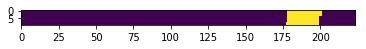

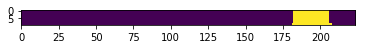

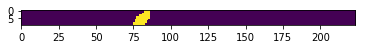

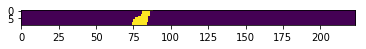

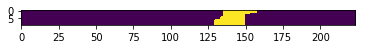

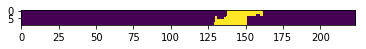

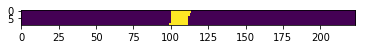

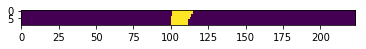

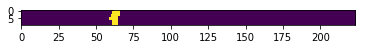

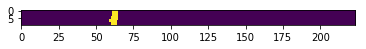

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61]]


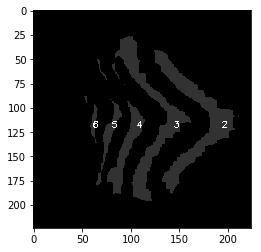

mid_new length: 5
middle sections collapsed (debug):


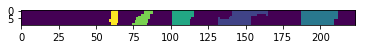

ORPHAN LEN 0, FAM LEN 5
counter 12


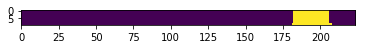

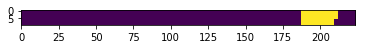

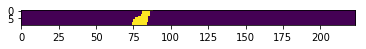

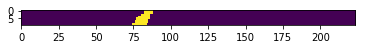

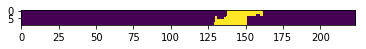

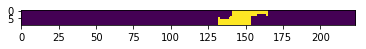

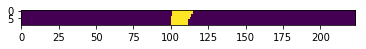

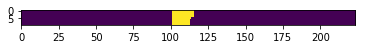

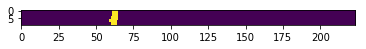

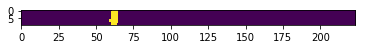

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61]]


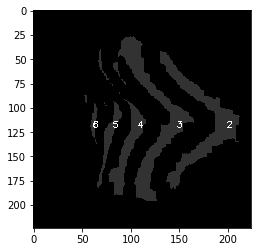

mid_new length: 5
middle sections collapsed (debug):


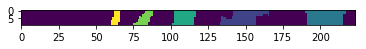

ORPHAN LEN 0, FAM LEN 5
counter 13


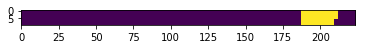

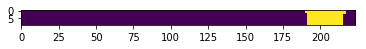

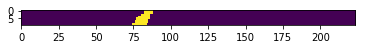

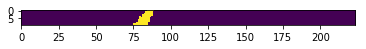

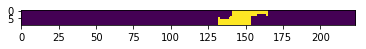

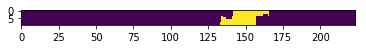

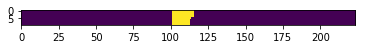

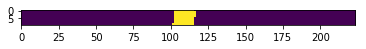

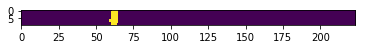

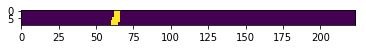

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63]]


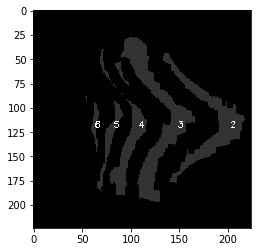

mid_new length: 5
middle sections collapsed (debug):


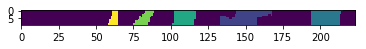

ORPHAN LEN 0, FAM LEN 5
counter 14


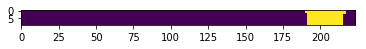

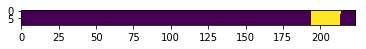

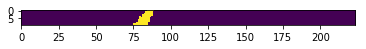

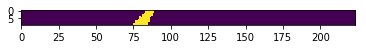

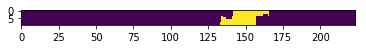

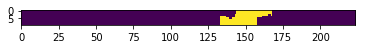

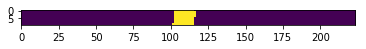

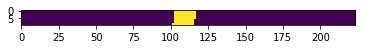

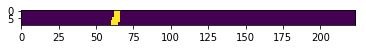

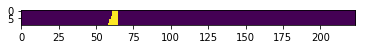

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61]]


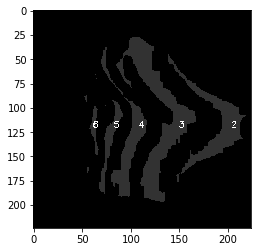

mid_new length: 6
middle sections collapsed (debug):


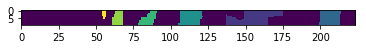

ORPHAN LEN 0, FAM LEN 5
counter 15


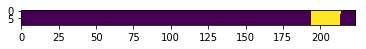

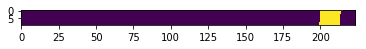

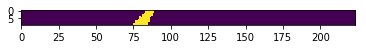

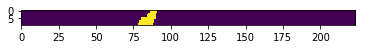

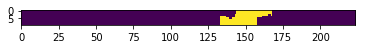

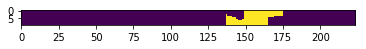

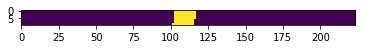

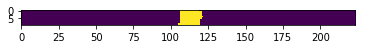

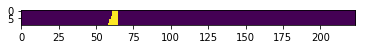

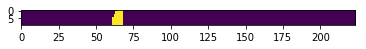

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64]]


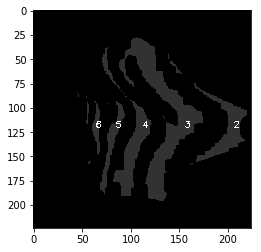

mid_new length: 6
middle sections collapsed (debug):


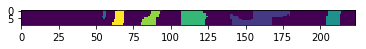

ORPHAN LEN 0, FAM LEN 5
counter 16


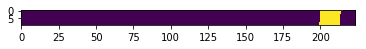

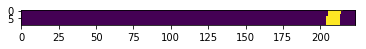

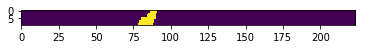

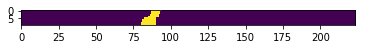

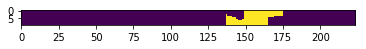

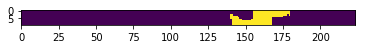

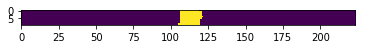

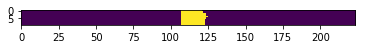

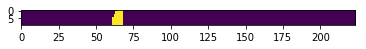

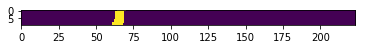

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65]]


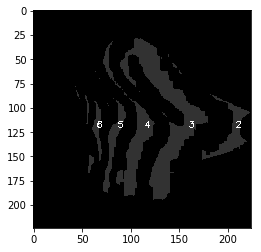

mid_new length: 6
middle sections collapsed (debug):


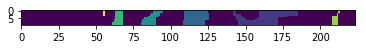

ORPHAN LEN 0, FAM LEN 5
counter 17


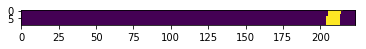

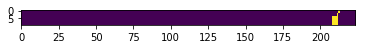

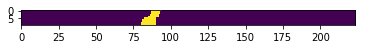

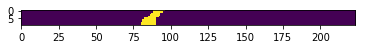

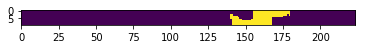

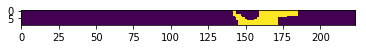

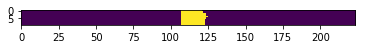

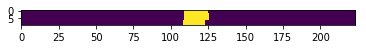

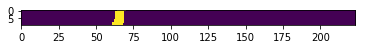

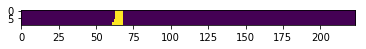

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64]]


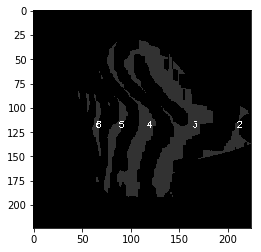

mid_new length: 6
middle sections collapsed (debug):


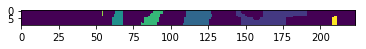

ORPHAN LEN 0, FAM LEN 5
counter 18


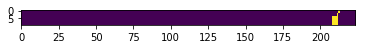

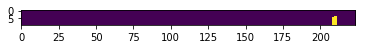

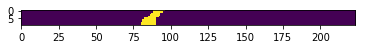

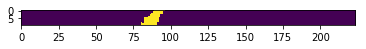

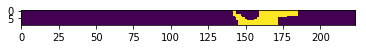

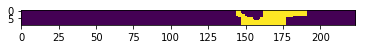

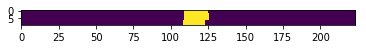

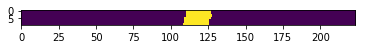

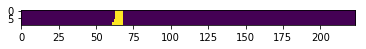

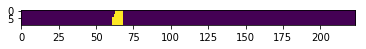

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64]]


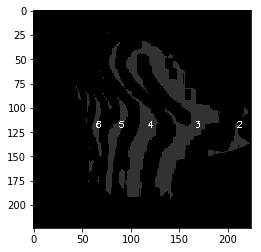

mid_new length: 5
middle sections collapsed (debug):


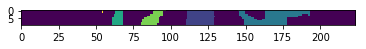

ORPHAN LEN 0, FAM LEN 5
counter 19


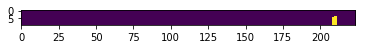

0 NO CHILD!!!


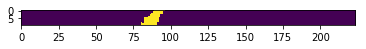

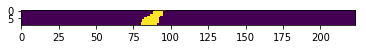

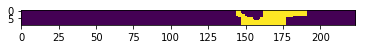

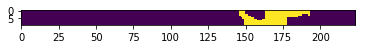

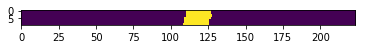

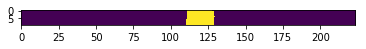

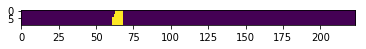

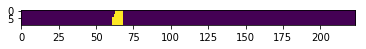

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64]]


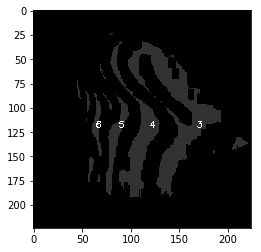

mid_new length: 5
middle sections collapsed (debug):


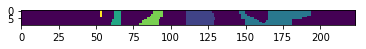

ORPHAN LEN 0, FAM LEN 4
counter 20


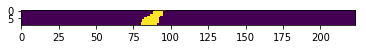

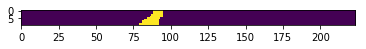

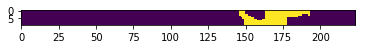

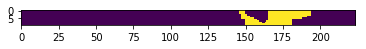

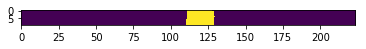

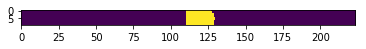

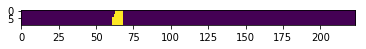

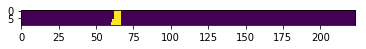

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63]]


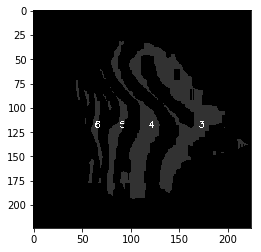

mid_new length: 6
middle sections collapsed (debug):


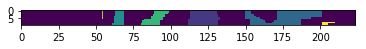

ORPHAN LEN 0, FAM LEN 4
counter 21


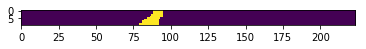

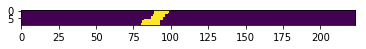

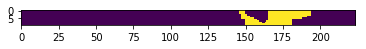

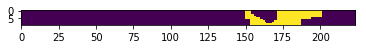

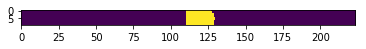

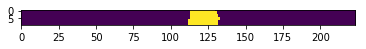

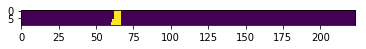

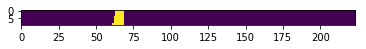

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65]]


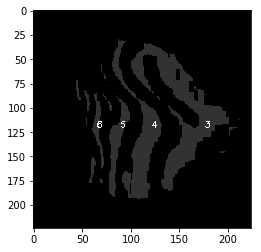

mid_new length: 6
middle sections collapsed (debug):


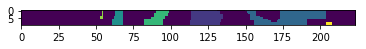

ORPHAN LEN 0, FAM LEN 4
counter 22


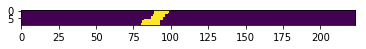

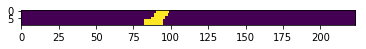

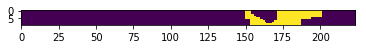

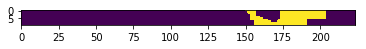

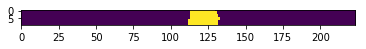

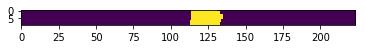

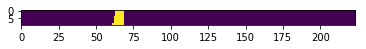

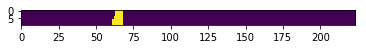

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64]]


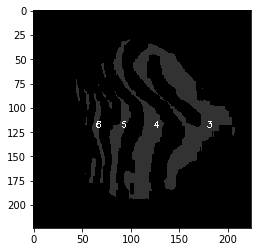

mid_new length: 5
middle sections collapsed (debug):


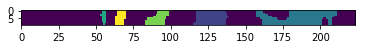

ORPHAN LEN 0, FAM LEN 4
counter 23


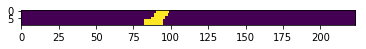

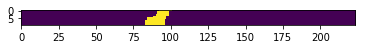

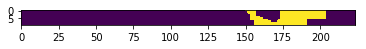

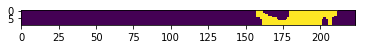

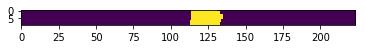

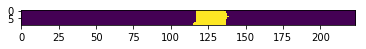

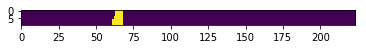

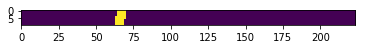

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66]]


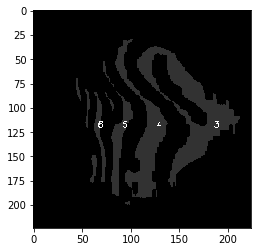

mid_new length: 5
middle sections collapsed (debug):


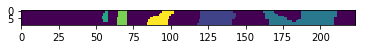

ORPHAN LEN 0, FAM LEN 4
counter 24


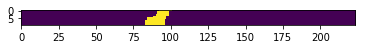

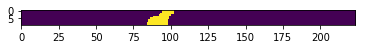

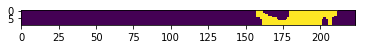

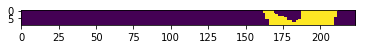

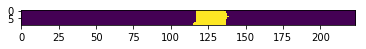

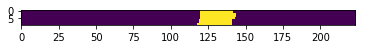

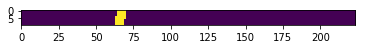

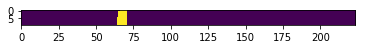

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67]]


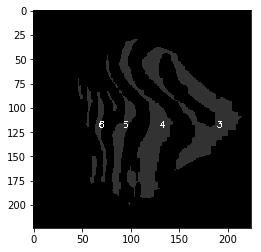

mid_new length: 5
middle sections collapsed (debug):


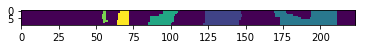

ORPHAN LEN 0, FAM LEN 4
counter 25


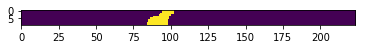

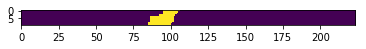

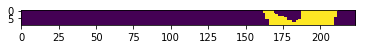

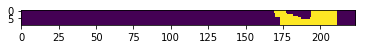

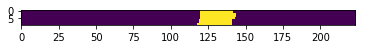

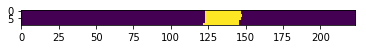

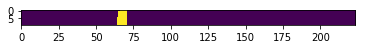

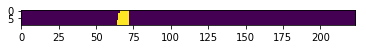

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67]]


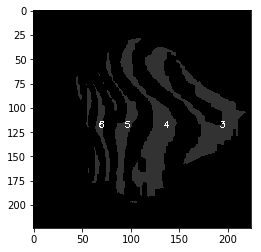

mid_new length: 5
middle sections collapsed (debug):


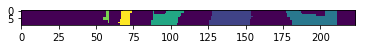

ORPHAN LEN 0, FAM LEN 4
counter 26


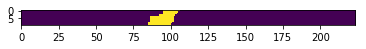

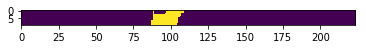

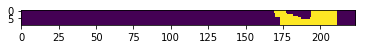

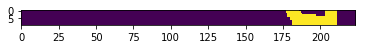

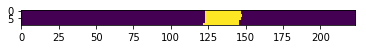

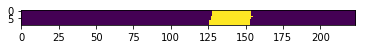

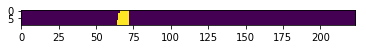

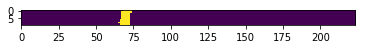

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69]]


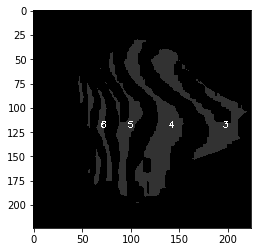

mid_new length: 5
middle sections collapsed (debug):


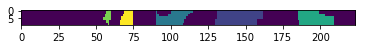

ORPHAN LEN 0, FAM LEN 4
counter 27


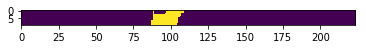

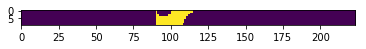

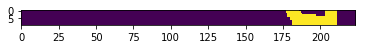

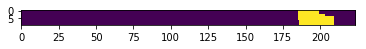

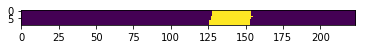

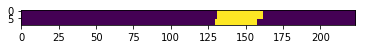

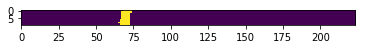

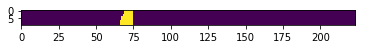

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70]]


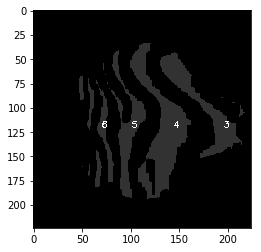

mid_new length: 5
middle sections collapsed (debug):


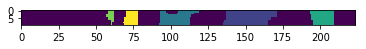

ORPHAN LEN 0, FAM LEN 4
counter 28


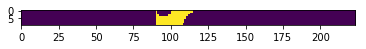

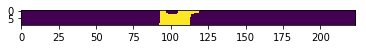

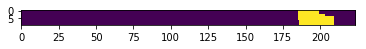

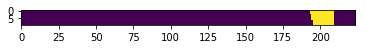

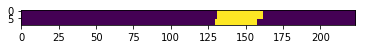

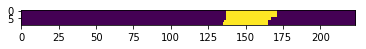

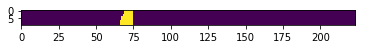

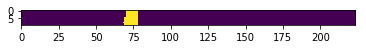

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73]]


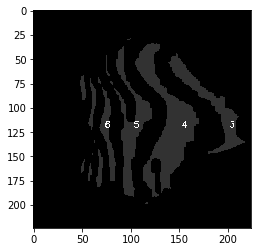

mid_new length: 5
middle sections collapsed (debug):


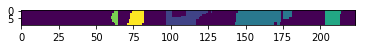

ORPHAN LEN 0, FAM LEN 4
counter 29


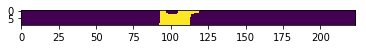

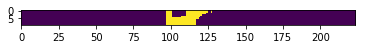

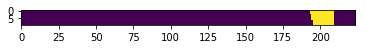

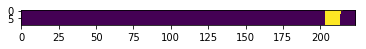

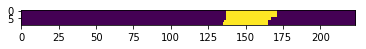

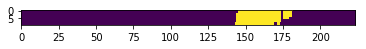

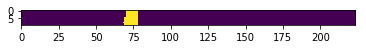

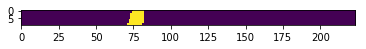

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76]]


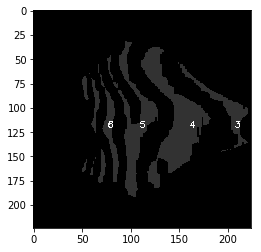

mid_new length: 5
middle sections collapsed (debug):


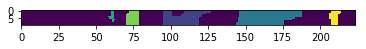

ORPHAN LEN 0, FAM LEN 4
counter 30


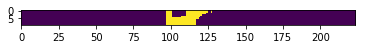

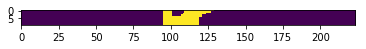

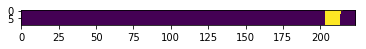

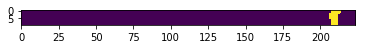

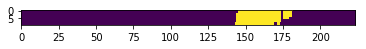

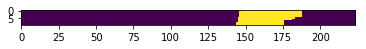

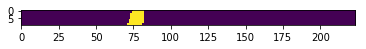

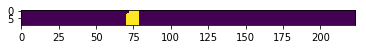

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74]]


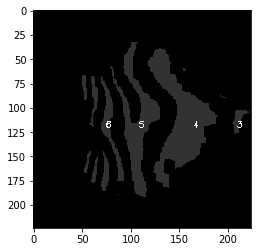

mid_new length: 5
middle sections collapsed (debug):


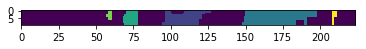

ORPHAN LEN 0, FAM LEN 4
counter 31


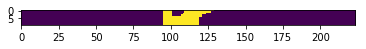

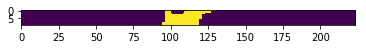

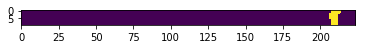

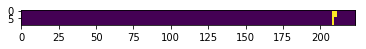

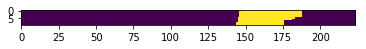

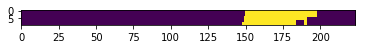

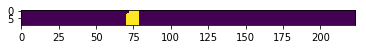

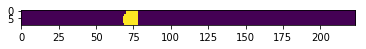

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72]]


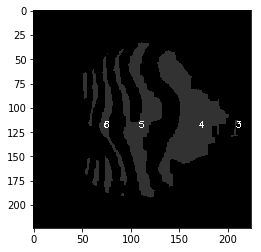

mid_new length: 4
middle sections collapsed (debug):


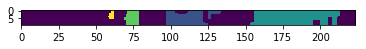

ORPHAN LEN 0, FAM LEN 4
counter 32


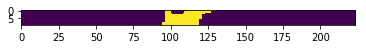

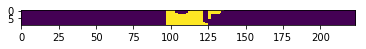

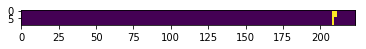

1 NO CHILD!!!


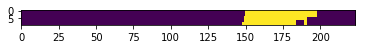

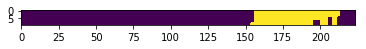

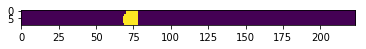

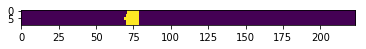

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74]]


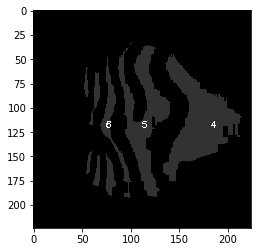

mid_new length: 3
middle sections collapsed (debug):


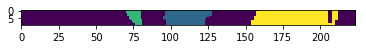

ORPHAN LEN 0, FAM LEN 3
counter 33


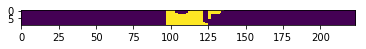

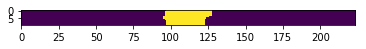

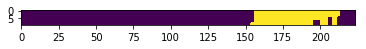

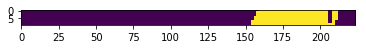

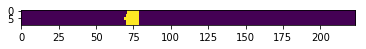

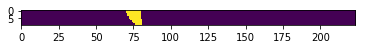

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75]]


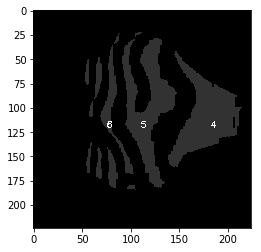

mid_new length: 3
middle sections collapsed (debug):


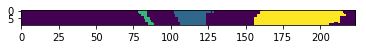

ORPHAN LEN 0, FAM LEN 3
counter 34


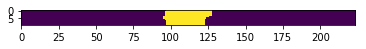

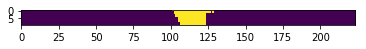

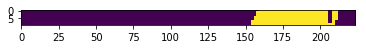

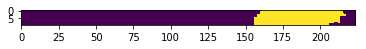

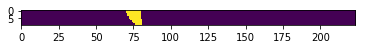

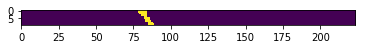

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82]]


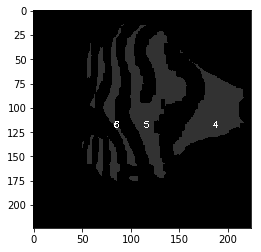

mid_new length: 4
middle sections collapsed (debug):


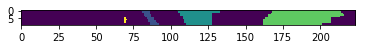

ORPHAN LEN 0, FAM LEN 3
counter 35


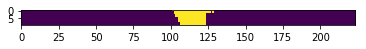

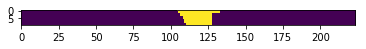

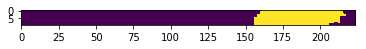

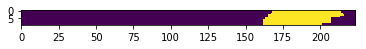

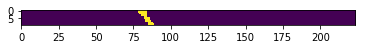

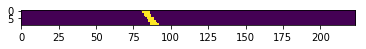

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85]]


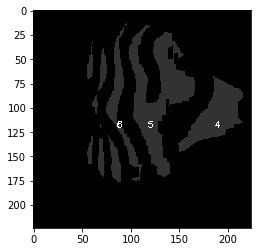

mid_new length: 5
middle sections collapsed (debug):


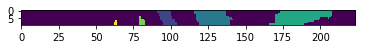

ORPHAN LEN 1, FAM LEN 3
counter 36


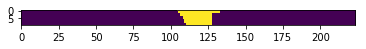

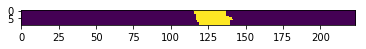

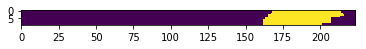

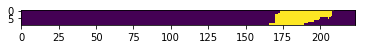

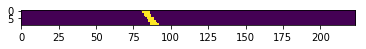

2 NO CHILD!!!
orphan #0


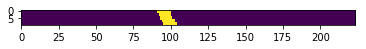

left_orphan: 96
before None check 96, j=0, val=None
before None check 96, j=1, val=127
after None check 96
second if 96
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96]]


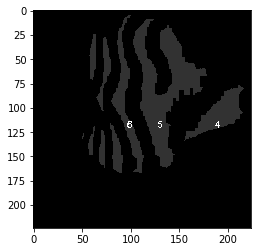

mid_new length: 7
middle sections collapsed (debug):


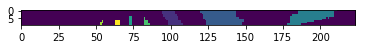

ORPHAN LEN 0, FAM LEN 3
counter 37


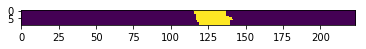

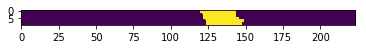

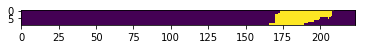

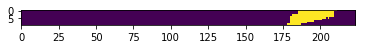

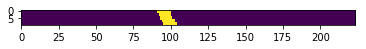

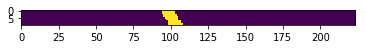

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99]]


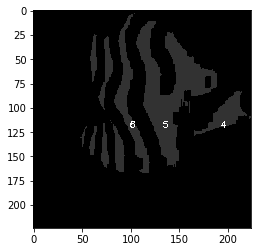

mid_new length: 4
middle sections collapsed (debug):


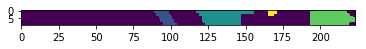

ORPHAN LEN 0, FAM LEN 3
counter 38


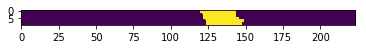

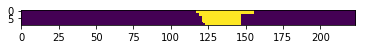

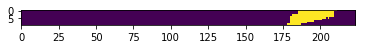

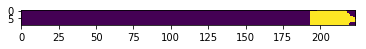

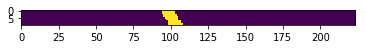

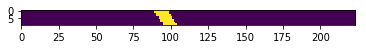

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133, 134], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95]]


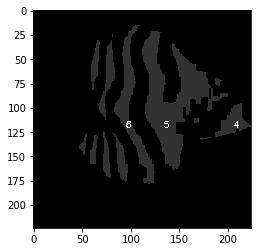

mid_new length: 4
middle sections collapsed (debug):


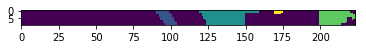

ORPHAN LEN 0, FAM LEN 3
counter 39


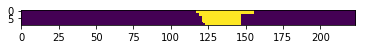

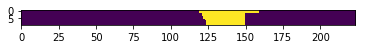

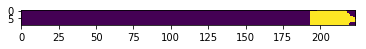

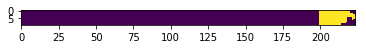

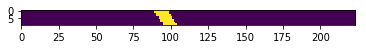

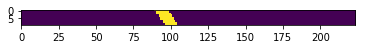

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209], [66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133, 134, 136], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96]]


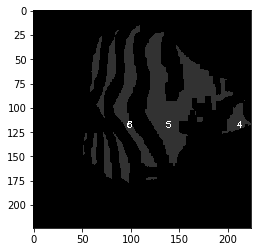

mid_new length: 5
middle sections collapsed (debug):


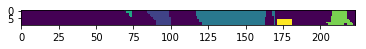

ORPHAN LEN 1, FAM LEN 3
counter 40


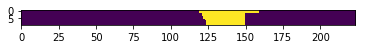

0 NO CHILD!!!


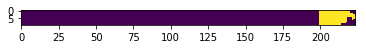

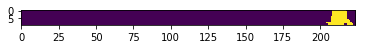

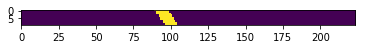

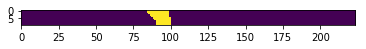

orphan #0


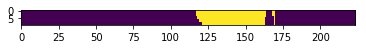

MIDDLE BLOB BEING INSERTED cX: 141
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212], [141], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92]]


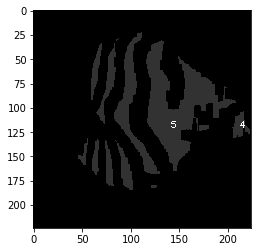

mid_new length: 4
middle sections collapsed (debug):


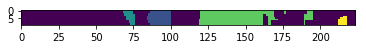

ORPHAN LEN 1, FAM LEN 3
counter 41


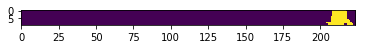

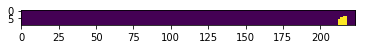

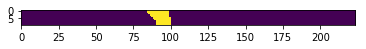

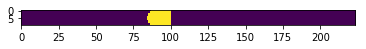

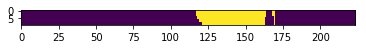

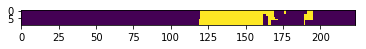

orphan #0


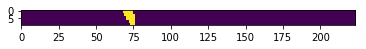

left_orphan: 72
before None check 72, j=0, val=92
after None check 72
first if 72
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214], [141, 146], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92], [72]]


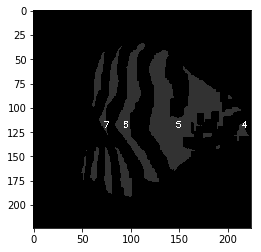

mid_new length: 4
middle sections collapsed (debug):


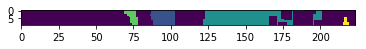

ORPHAN LEN 0, FAM LEN 4
counter 42


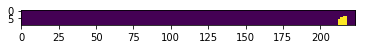

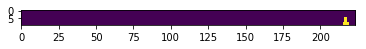

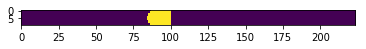

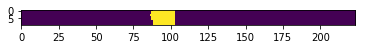

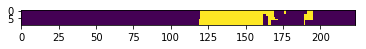

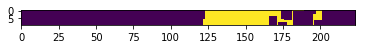

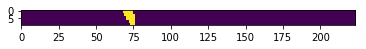

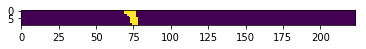

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216], [141, 146, 151], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94], [72, 73]]


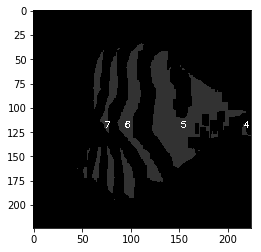

mid_new length: 5
middle sections collapsed (debug):


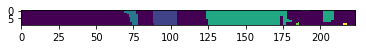

ORPHAN LEN 0, FAM LEN 4
counter 43


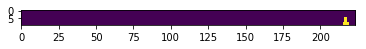

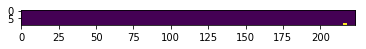

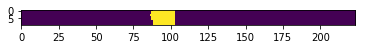

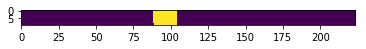

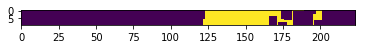

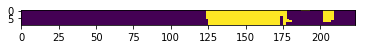

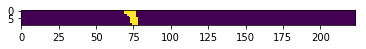

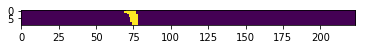

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216], [141, 146, 151, 155], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95], [72, 73, 74]]


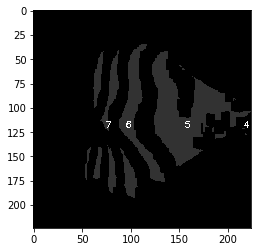

mid_new length: 4
middle sections collapsed (debug):


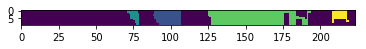

ORPHAN LEN 1, FAM LEN 4
counter 44


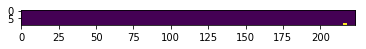

0 NO CHILD!!!


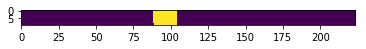

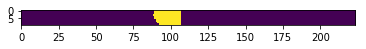

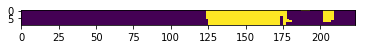

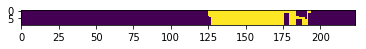

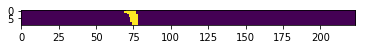

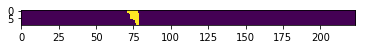

orphan #0


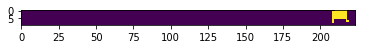

right_orphan: 212
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212], [141, 146, 151, 155, 155], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97], [72, 73, 74, 75]]


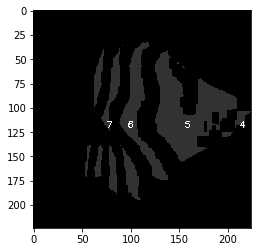

mid_new length: 3
middle sections collapsed (debug):


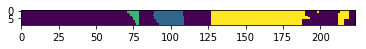

ORPHAN LEN 0, FAM LEN 4
counter 45


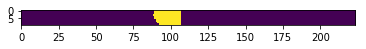

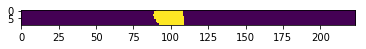

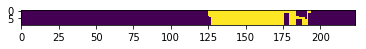

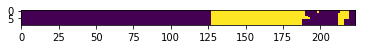

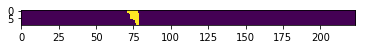

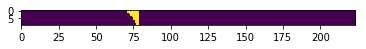

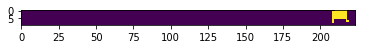

3 NO CHILD!!!
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98], [72, 73, 74, 75, 75]]


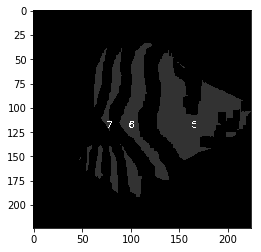

mid_new length: 3
middle sections collapsed (debug):


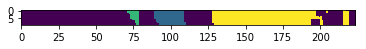

ORPHAN LEN 0, FAM LEN 3
counter 46


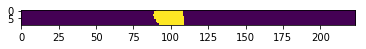

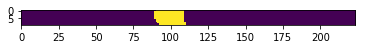

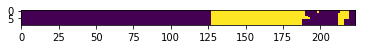

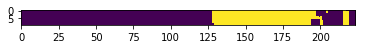

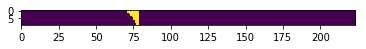

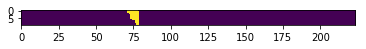

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98], [72, 73, 74, 75, 75, 75]]


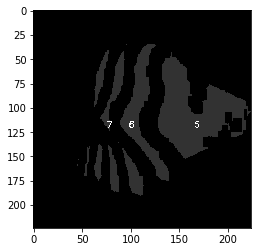

mid_new length: 3
middle sections collapsed (debug):


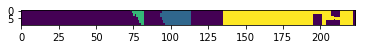

ORPHAN LEN 0, FAM LEN 3
counter 47


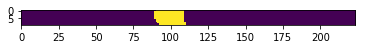

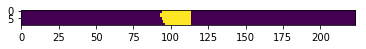

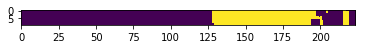

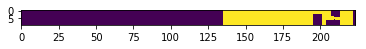

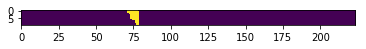

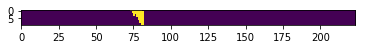

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103], [72, 73, 74, 75, 75, 75, 78]]


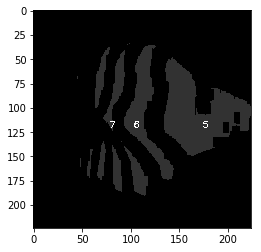

mid_new length: 3
middle sections collapsed (debug):


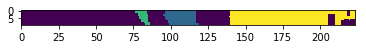

ORPHAN LEN 0, FAM LEN 3
counter 48


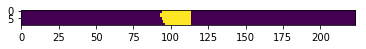

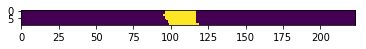

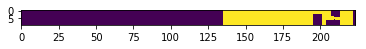

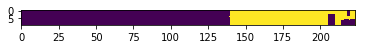

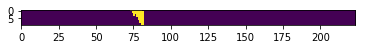

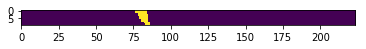

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106], [72, 73, 74, 75, 75, 75, 78, 81]]


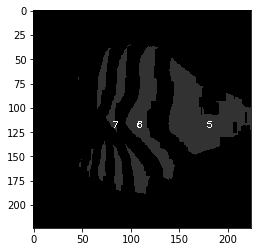

mid_new length: 3
middle sections collapsed (debug):


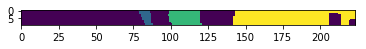

ORPHAN LEN 0, FAM LEN 3
counter 49


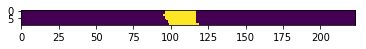

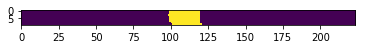

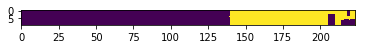

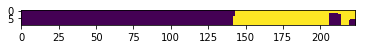

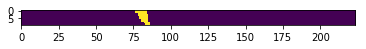

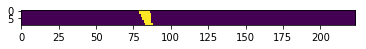

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109], [72, 73, 74, 75, 75, 75, 78, 81, 83]]


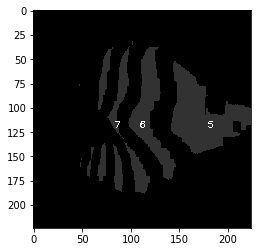

mid_new length: 3
middle sections collapsed (debug):


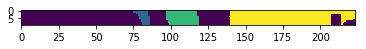

ORPHAN LEN 0, FAM LEN 3
counter 50


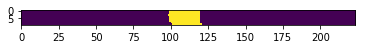

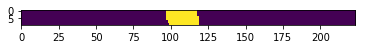

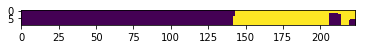

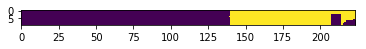

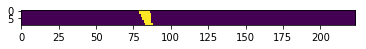

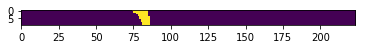

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81]]


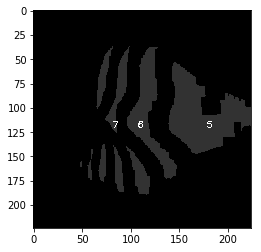

mid_new length: 3
middle sections collapsed (debug):


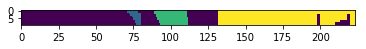

ORPHAN LEN 0, FAM LEN 3
counter 51


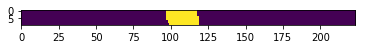

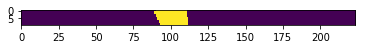

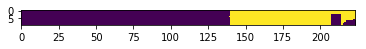

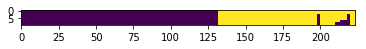

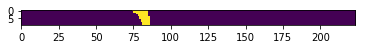

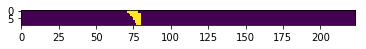

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75]]


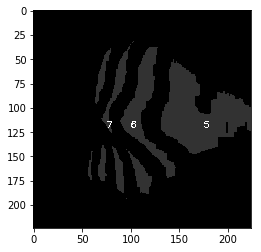

mid_new length: 3
middle sections collapsed (debug):


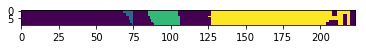

ORPHAN LEN 0, FAM LEN 3
counter 52


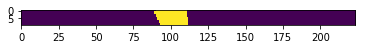

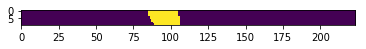

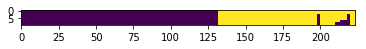

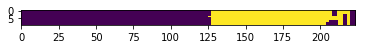

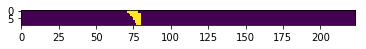

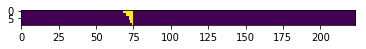

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72]]


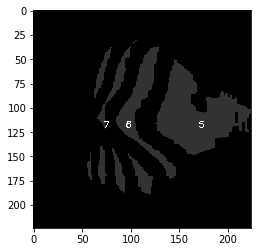

mid_new length: 3
middle sections collapsed (debug):


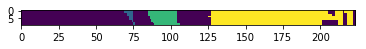

ORPHAN LEN 0, FAM LEN 3
counter 53


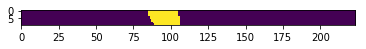

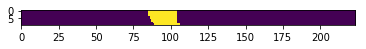

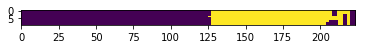

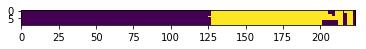

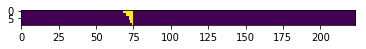

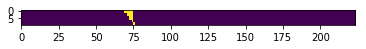

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72, 72]]


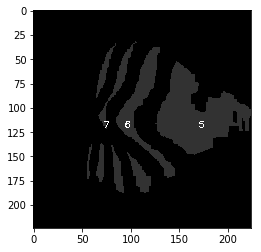

mid_new length: 3
middle sections collapsed (debug):


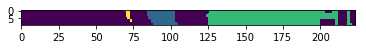

ORPHAN LEN 0, FAM LEN 3
counter 54


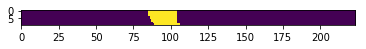

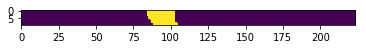

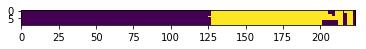

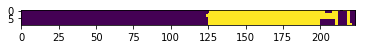

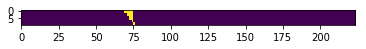

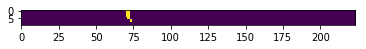

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72, 72, 71]]


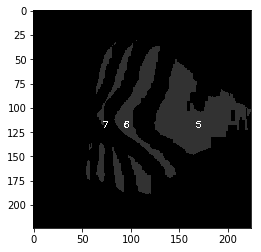

mid_new length: 3
middle sections collapsed (debug):


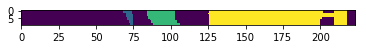

ORPHAN LEN 0, FAM LEN 3
counter 55


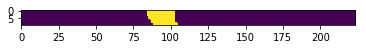

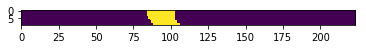

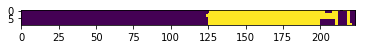

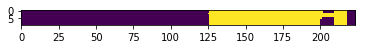

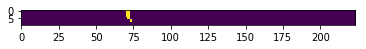

2 NO CHILD!!!
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72, 72, 71, None]

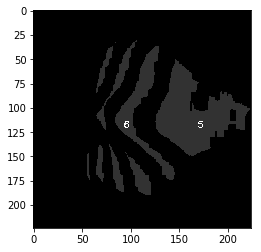

mid_new length: 3
middle sections collapsed (debug):


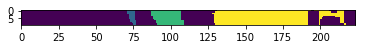

ORPHAN LEN 0, FAM LEN 2
counter 56


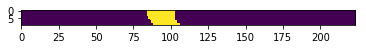

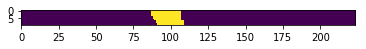

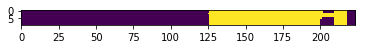

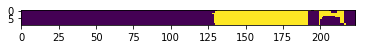

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72, 72, 71, None]]


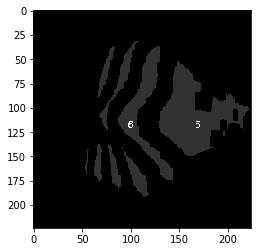

mid_new length: 3
middle sections collapsed (debug):


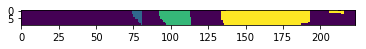

ORPHAN LEN 0, FAM LEN 2
counter 57


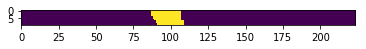

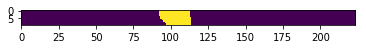

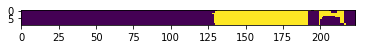

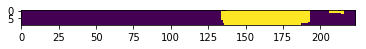

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102], [72, 73, 74, 75, 75, 75, 78, 81, 83, 81, 75, 72, 72, 71, 

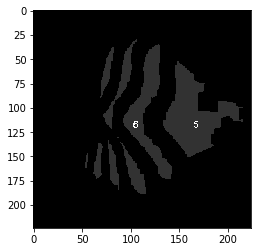

mid_new length: 3
middle sections collapsed (debug):


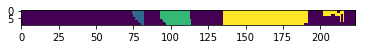

ORPHAN LEN 1, FAM LEN 2
counter 58


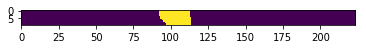

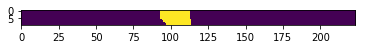

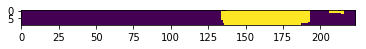

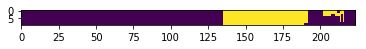

orphan #0


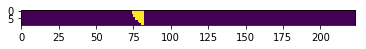

left_orphan: 78
before None check 78, j=0, val=None
before None check 78, j=1, val=103
after None check 78
second if 78
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94,

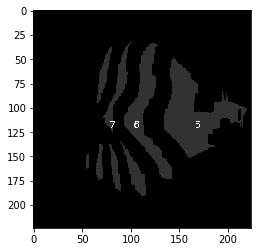

mid_new length: 3
middle sections collapsed (debug):


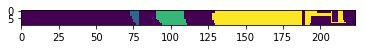

ORPHAN LEN 0, FAM LEN 3
counter 59


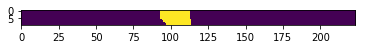

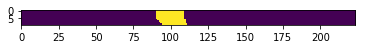

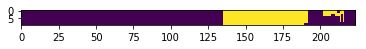

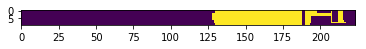

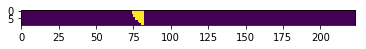

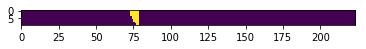

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99], [72, 73, 74, 75, 75, 75, 78, 81, 83, 8

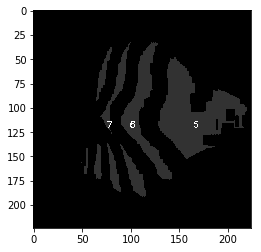

mid_new length: 3
middle sections collapsed (debug):


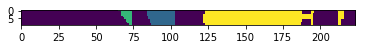

ORPHAN LEN 1, FAM LEN 3
counter 60


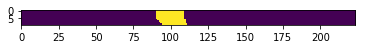

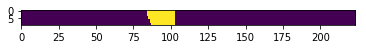

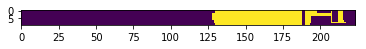

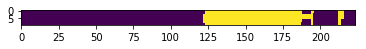

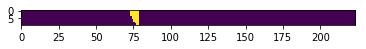

2 NO CHILD!!!
orphan #0


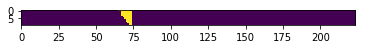

left_orphan: 70
before None check 70, j=0, val=None
before None check 70, j=1, val=93
after None check 70
second if 70
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92

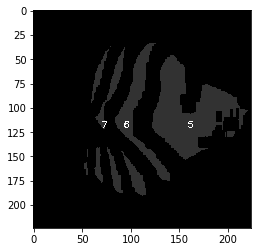

mid_new length: 3
middle sections collapsed (debug):


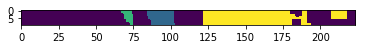

ORPHAN LEN 0, FAM LEN 3
counter 61


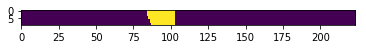

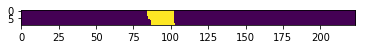

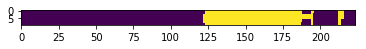

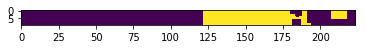

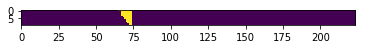

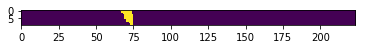

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93], [72, 73, 74, 75, 75,

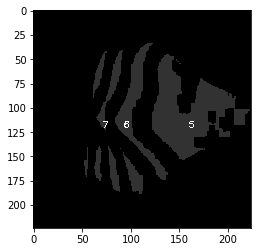

mid_new length: 4
middle sections collapsed (debug):


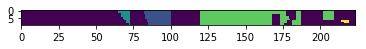

ORPHAN LEN 0, FAM LEN 3
counter 62


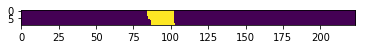

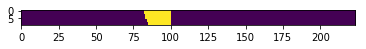

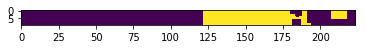

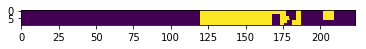

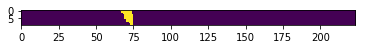

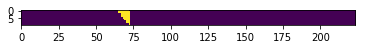

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91], [72, 73, 74

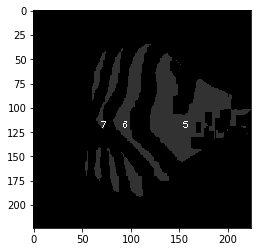

mid_new length: 5
middle sections collapsed (debug):


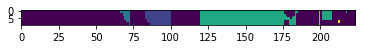

ORPHAN LEN 0, FAM LEN 3
counter 63


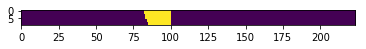

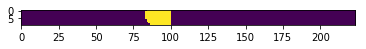

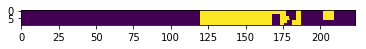

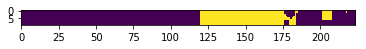

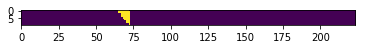

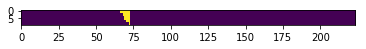

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91], [7

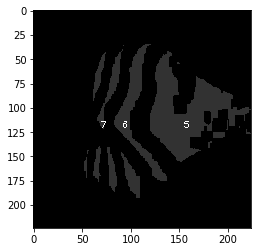

mid_new length: 4
middle sections collapsed (debug):


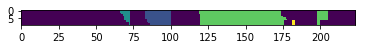

ORPHAN LEN 0, FAM LEN 3
counter 64


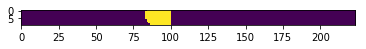

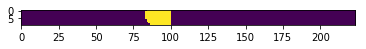

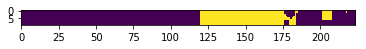

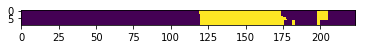

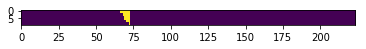

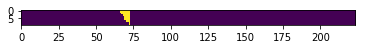

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91

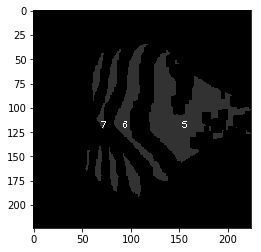

mid_new length: 5
middle sections collapsed (debug):


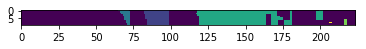

ORPHAN LEN 0, FAM LEN 3
counter 65


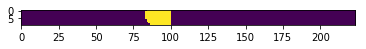

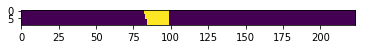

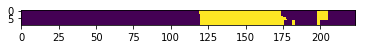

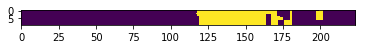

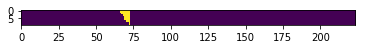

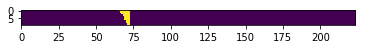

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 9

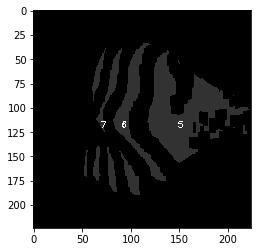

mid_new length: 6
middle sections collapsed (debug):


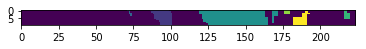

ORPHAN LEN 1, FAM LEN 3
counter 66


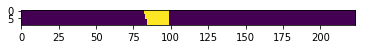

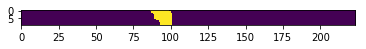

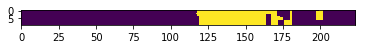

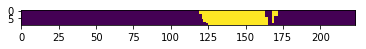

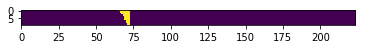

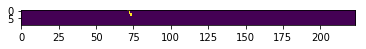

orphan #0


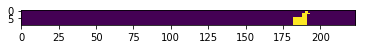

right_orphan: 186
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93,

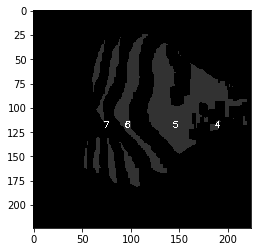

mid_new length: 4
middle sections collapsed (debug):


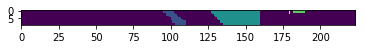

ORPHAN LEN 0, FAM LEN 4
counter 67


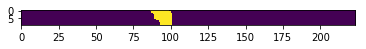

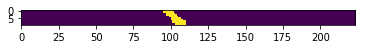

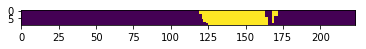

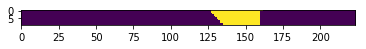

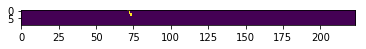

2 NO CHILD!!!


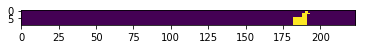

3 NO CHILD!!!
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 

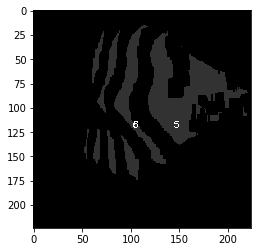

mid_new length: 4
middle sections collapsed (debug):


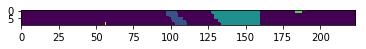

ORPHAN LEN 0, FAM LEN 2
counter 68


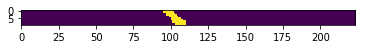

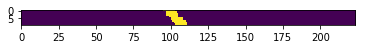

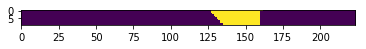

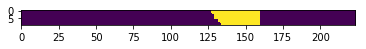

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 9

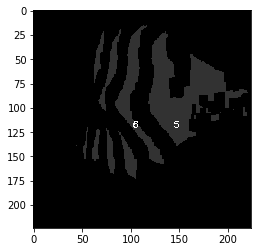

mid_new length: 3
middle sections collapsed (debug):


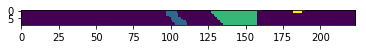

ORPHAN LEN 0, FAM LEN 2
counter 69


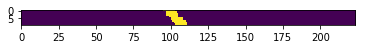

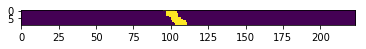

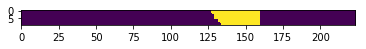

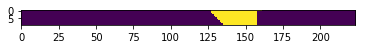

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 

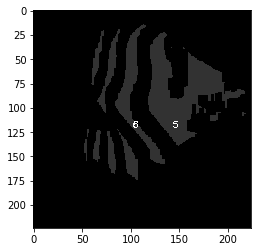

mid_new length: 3
middle sections collapsed (debug):


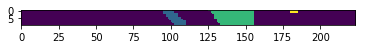

ORPHAN LEN 0, FAM LEN 2
counter 70


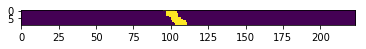

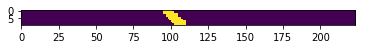

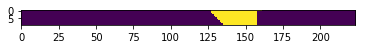

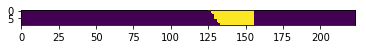

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94,

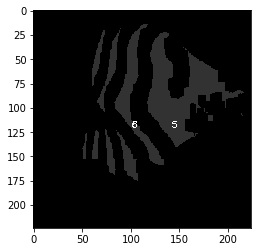

mid_new length: 7
middle sections collapsed (debug):


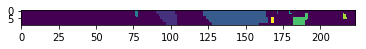

ORPHAN LEN 1, FAM LEN 2
counter 71


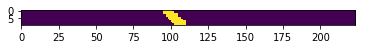

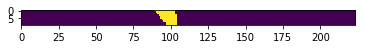

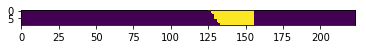

1 NO CHILD!!!
orphan #0


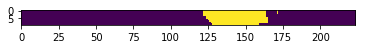

right_orphan: 143
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103

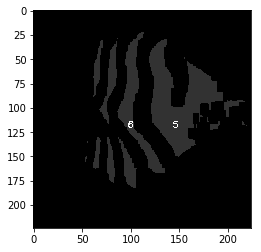

mid_new length: 6
middle sections collapsed (debug):


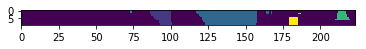

ORPHAN LEN 0, FAM LEN 2
counter 72


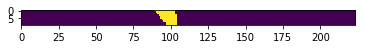

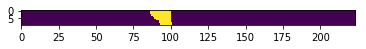

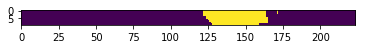

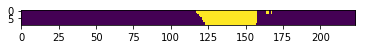

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 1

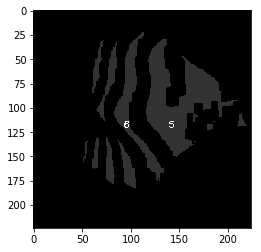

mid_new length: 2
middle sections collapsed (debug):


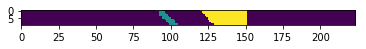

ORPHAN LEN 0, FAM LEN 2
counter 73


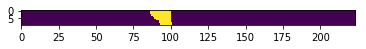

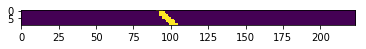

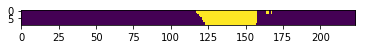

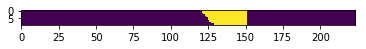

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 1

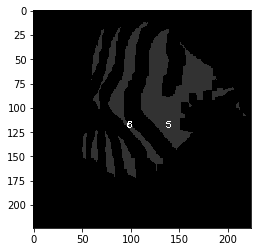

mid_new length: 3
middle sections collapsed (debug):


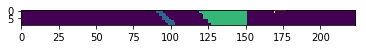

ORPHAN LEN 0, FAM LEN 2
counter 74


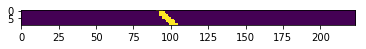

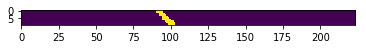

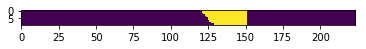

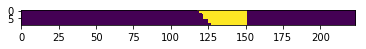

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 1

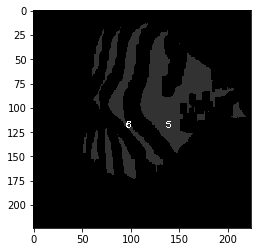

mid_new length: 4
middle sections collapsed (debug):


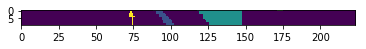

ORPHAN LEN 0, FAM LEN 2
counter 75


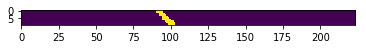

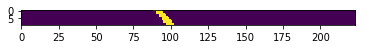

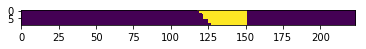

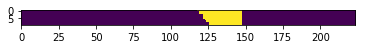

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 1

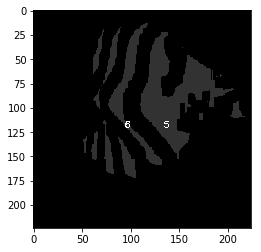

mid_new length: 5
middle sections collapsed (debug):


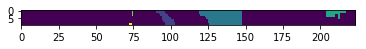

ORPHAN LEN 0, FAM LEN 2
counter 76


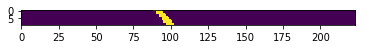

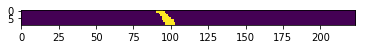

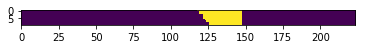

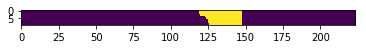

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 

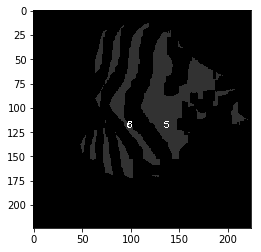

mid_new length: 6
middle sections collapsed (debug):


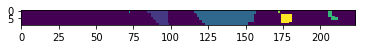

ORPHAN LEN 1, FAM LEN 2
counter 77


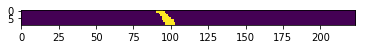

0 NO CHILD!!!


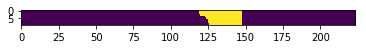

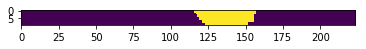

orphan #0


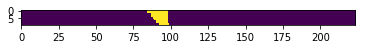

left_orphan: 92
before None check 92, j=0, val=None
before None check 92, j=1, val=None
before None check 92, j=2, val=136
after None check 92
second if 92
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136], [53, 55, 55, 57, 59, 59, 61, 62, 6

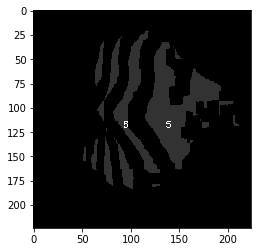

mid_new length: 5
middle sections collapsed (debug):


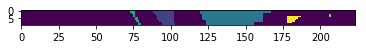

ORPHAN LEN 0, FAM LEN 2
counter 78


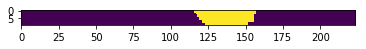

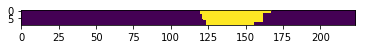

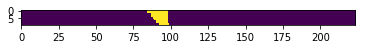

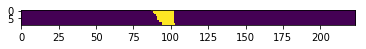

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95

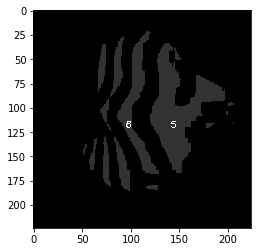

mid_new length: 4
middle sections collapsed (debug):


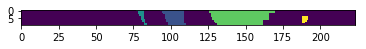

ORPHAN LEN 0, FAM LEN 2
counter 79


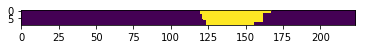

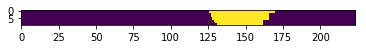

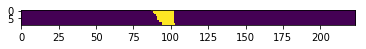

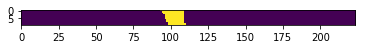

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 9

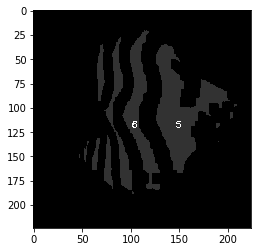

mid_new length: 5
middle sections collapsed (debug):


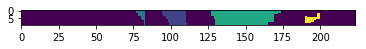

ORPHAN LEN 0, FAM LEN 2
counter 80


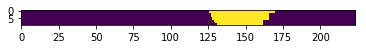

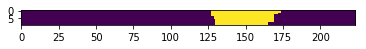

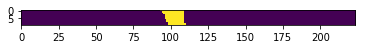

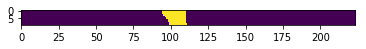

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 

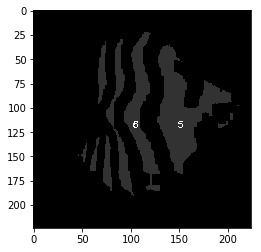

mid_new length: 6
middle sections collapsed (debug):


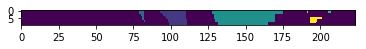

ORPHAN LEN 0, FAM LEN 2
counter 81


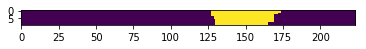

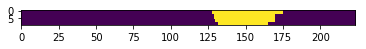

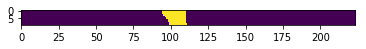

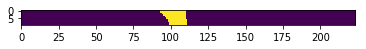

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96,

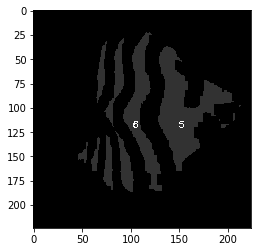

mid_new length: 4
middle sections collapsed (debug):


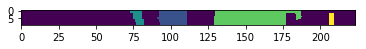

ORPHAN LEN 1, FAM LEN 2
counter 82


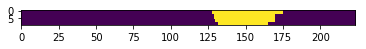

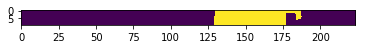

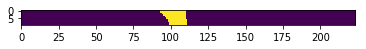

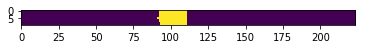

orphan #0


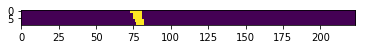

left_orphan: 77
before None check 77, j=0, val=None
before None check 77, j=1, val=101
after None check 77
second if 77
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 

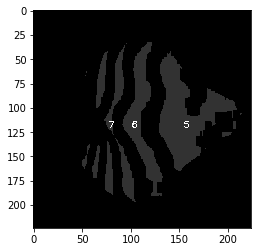

mid_new length: 3
middle sections collapsed (debug):


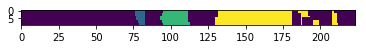

ORPHAN LEN 0, FAM LEN 3
counter 83


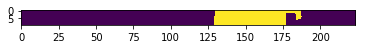

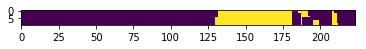

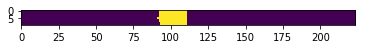

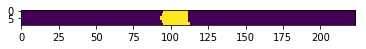

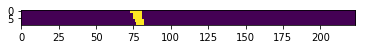

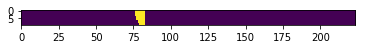

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 9

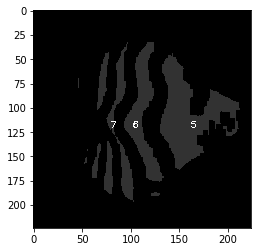

mid_new length: 3
middle sections collapsed (debug):


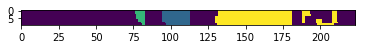

ORPHAN LEN 0, FAM LEN 3
counter 84


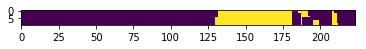

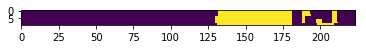

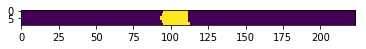

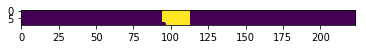

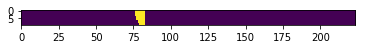

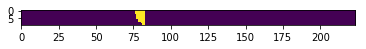

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 

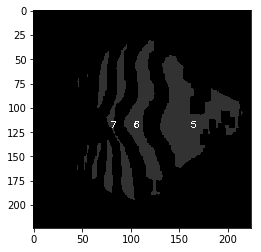

mid_new length: 3
middle sections collapsed (debug):


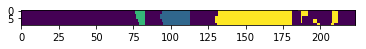

ORPHAN LEN 0, FAM LEN 3
counter 85


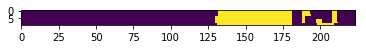

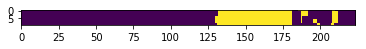

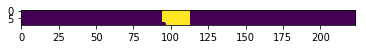

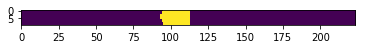

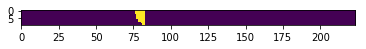

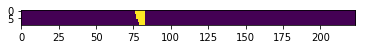

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, N

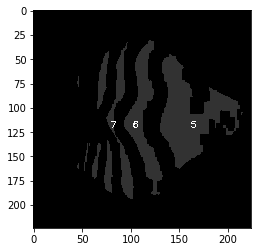

mid_new length: 3
middle sections collapsed (debug):


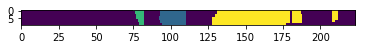

ORPHAN LEN 0, FAM LEN 3
counter 86


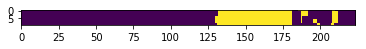

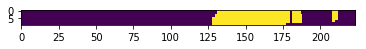

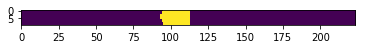

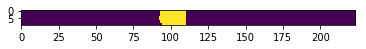

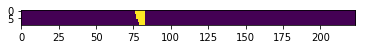

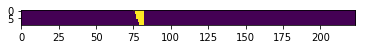

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 

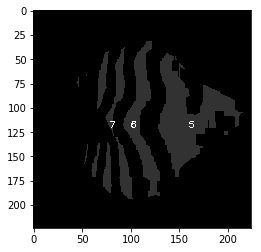

mid_new length: 4
middle sections collapsed (debug):


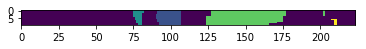

ORPHAN LEN 0, FAM LEN 3
counter 87


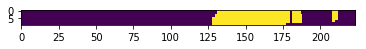

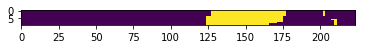

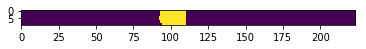

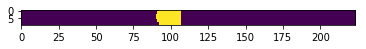

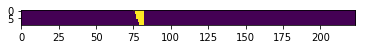

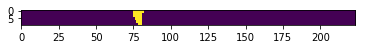

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75,

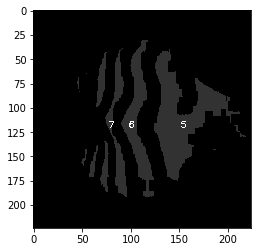

mid_new length: 4
middle sections collapsed (debug):


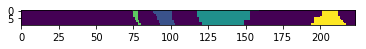

ORPHAN LEN 1, FAM LEN 3
counter 88


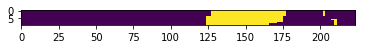

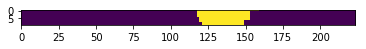

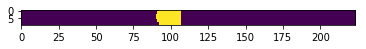

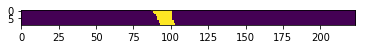

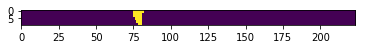

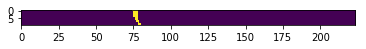

orphan #0


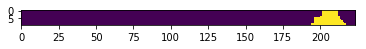

right_orphan: 205
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69,

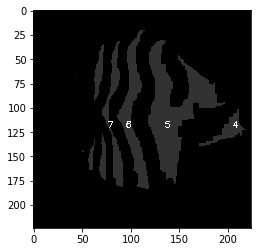

mid_new length: 6
middle sections collapsed (debug):


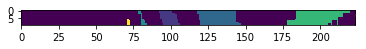

ORPHAN LEN 1, FAM LEN 4
counter 89


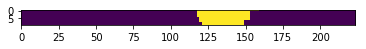

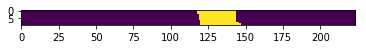

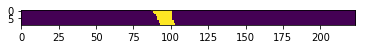

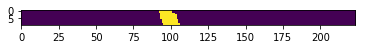

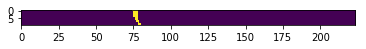

2 NO CHILD!!!


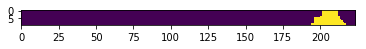

3 NO CHILD!!!
orphan #0


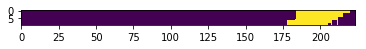

right_orphan: 197
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64,

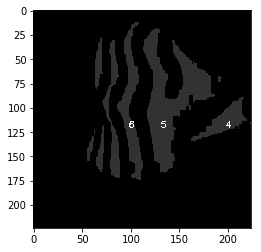

mid_new length: 6
middle sections collapsed (debug):


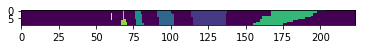

ORPHAN LEN 0, FAM LEN 3
counter 90


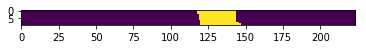

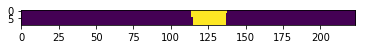

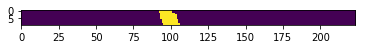

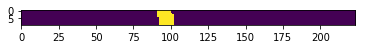

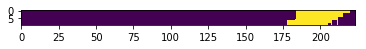

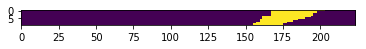

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67,

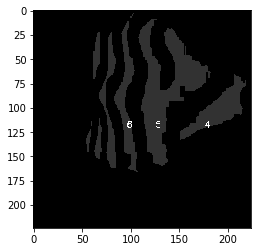

mid_new length: 6
middle sections collapsed (debug):


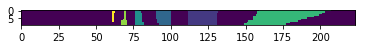

ORPHAN LEN 0, FAM LEN 3
counter 91


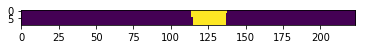

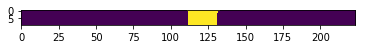

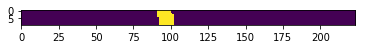

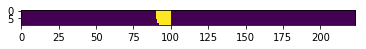

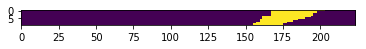

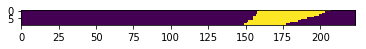

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 6

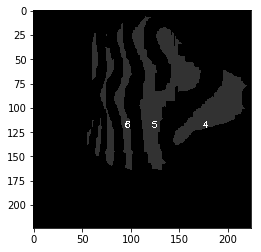

mid_new length: 6
middle sections collapsed (debug):


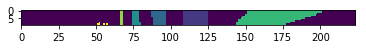

ORPHAN LEN 1, FAM LEN 3
counter 92


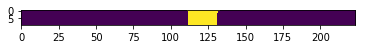

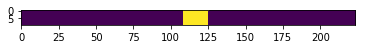

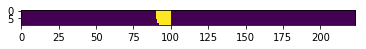

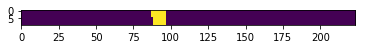

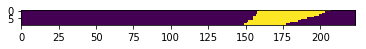

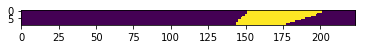

orphan #0


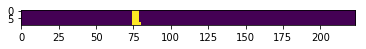

left_orphan: 76
before None check 76, j=0, val=None
before None check 76, j=1, val=91
after None check 76
second if 76
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 1

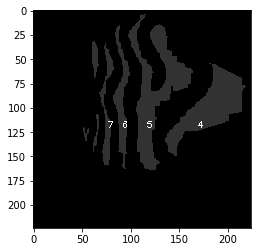

mid_new length: 3
middle sections collapsed (debug):


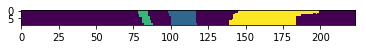

ORPHAN LEN 1, FAM LEN 4
counter 93


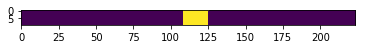

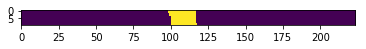

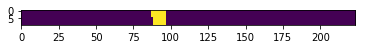

1 NO CHILD!!!


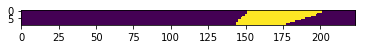

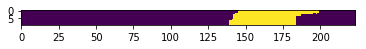

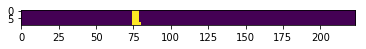

3 NO CHILD!!!
orphan #0


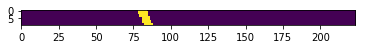

left_orphan: 82
before None check 82, j=0, val=None
before None check 82, j=1, val=None
before None check 82, j=2, val=107
after None check 82
second if 82
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136,

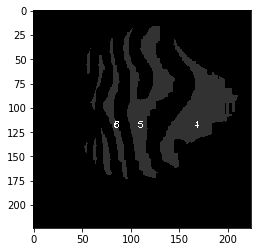

mid_new length: 4
middle sections collapsed (debug):


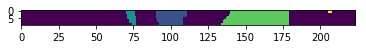

ORPHAN LEN 1, FAM LEN 3
counter 94


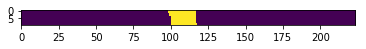

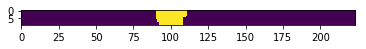

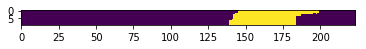

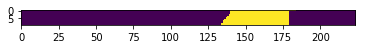

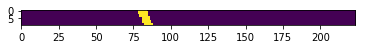

2 NO CHILD!!!
orphan #0


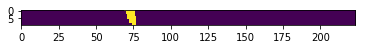

left_orphan: 73
before None check 73, j=0, val=None
before None check 73, j=1, val=None
before None check 73, j=2, val=99
after None check 73
second if 73
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 

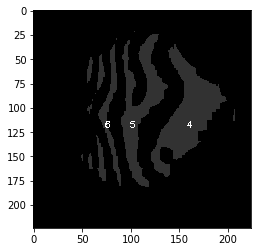

mid_new length: 4
middle sections collapsed (debug):


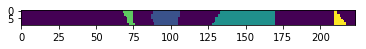

ORPHAN LEN 0, FAM LEN 3
counter 95


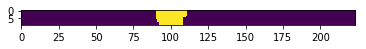

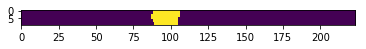

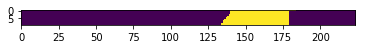

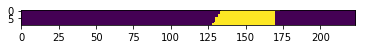

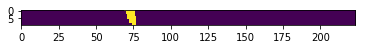

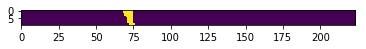

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61,

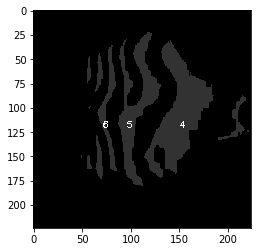

mid_new length: 4
middle sections collapsed (debug):


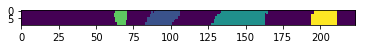

ORPHAN LEN 2, FAM LEN 3
counter 96


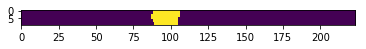

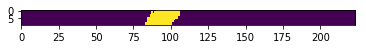

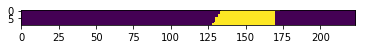

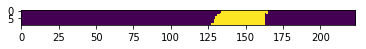

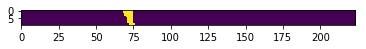

2 NO CHILD!!!
orphan #0


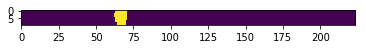

orphan #1


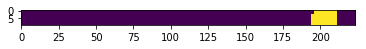

right_orphan: 202
left_orphan: 66
before None check 66, j=0, val=None
before None check 66, j=1, val=None
before None check 66, j=2, val=94
after None check 66
second if 66
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, Non

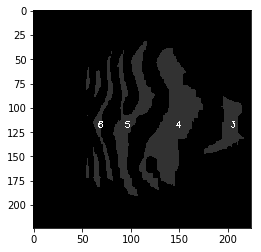

mid_new length: 4
middle sections collapsed (debug):


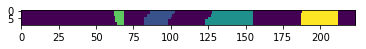

ORPHAN LEN 1, FAM LEN 4
counter 97


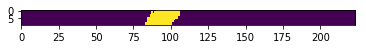

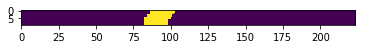

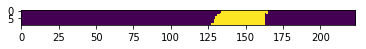

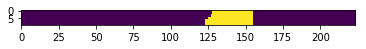

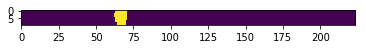

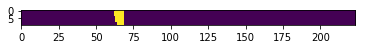

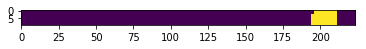

3 NO CHILD!!!
orphan #0


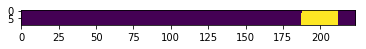

right_orphan: 199
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91], [53,

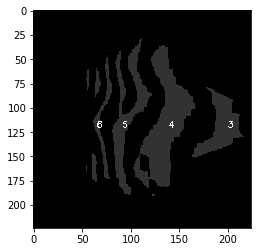

mid_new length: 4
middle sections collapsed (debug):


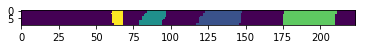

ORPHAN LEN 0, FAM LEN 4
counter 98


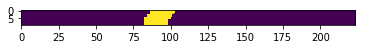

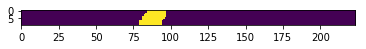

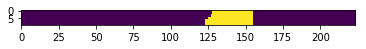

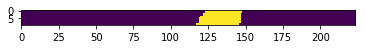

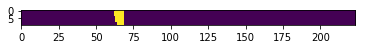

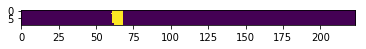

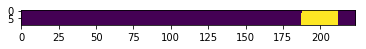

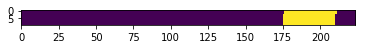

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87], [53, 55,

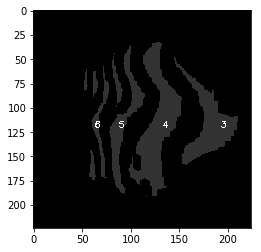

mid_new length: 4
middle sections collapsed (debug):


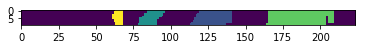

ORPHAN LEN 0, FAM LEN 4
counter 99


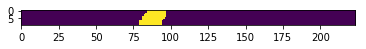

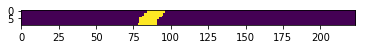

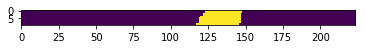

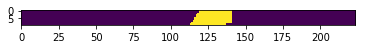

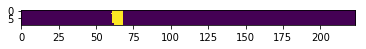

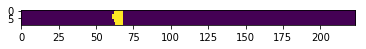

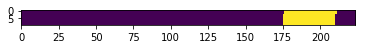

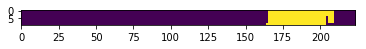

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87,

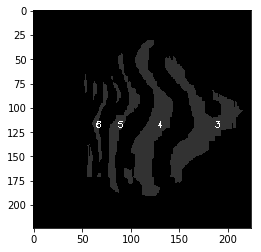

mid_new length: 4
middle sections collapsed (debug):


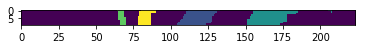

ORPHAN LEN 0, FAM LEN 4
counter 100


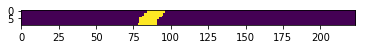

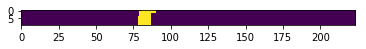

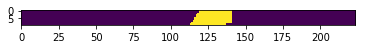

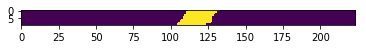

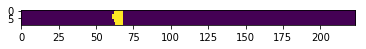

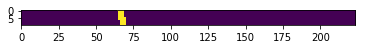

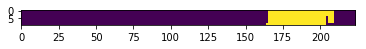

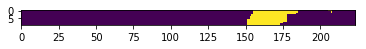

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 9

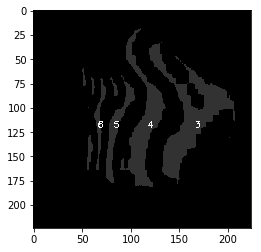

mid_new length: 5
middle sections collapsed (debug):


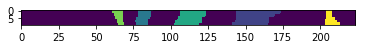

ORPHAN LEN 1, FAM LEN 4
counter 101


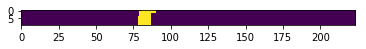

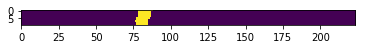

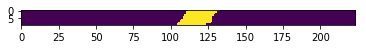

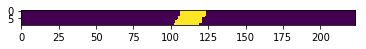

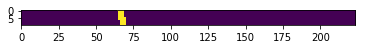

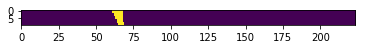

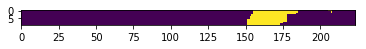

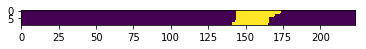

orphan #0


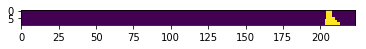

right_orphan: 206
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 1

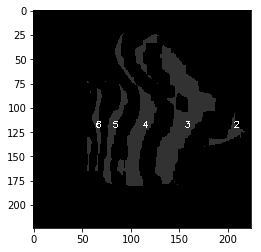

mid_new length: 5
middle sections collapsed (debug):


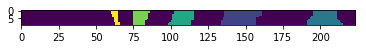

ORPHAN LEN 1, FAM LEN 5
counter 102


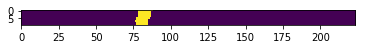

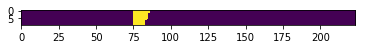

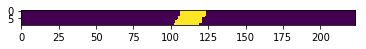

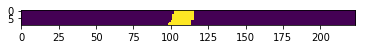

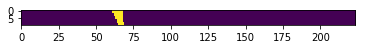

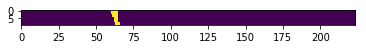

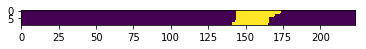

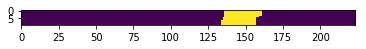

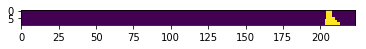

4 NO CHILD!!!
orphan #0


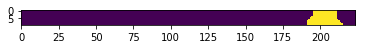

right_orphan: 202
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 

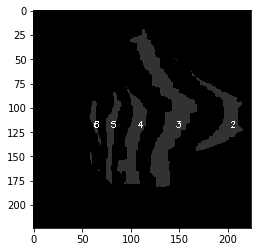

mid_new length: 5
middle sections collapsed (debug):


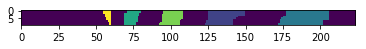

ORPHAN LEN 1, FAM LEN 5
counter 103


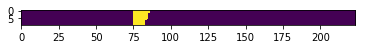

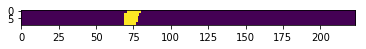

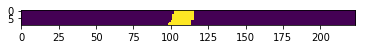

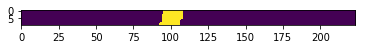

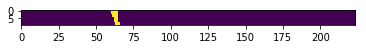

2 NO CHILD!!!


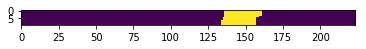

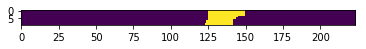

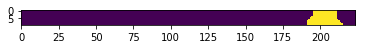

4 NO CHILD!!!
orphan #0


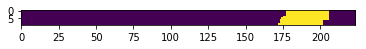

right_orphan: 189
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148,

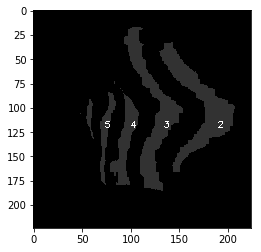

mid_new length: 5
middle sections collapsed (debug):


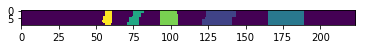

ORPHAN LEN 1, FAM LEN 4
counter 104


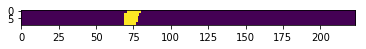

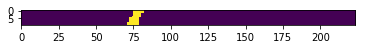

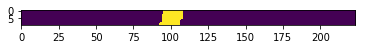

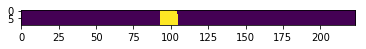

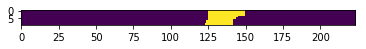

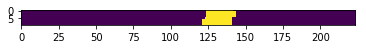

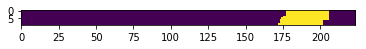

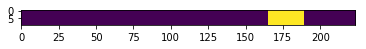

orphan #0


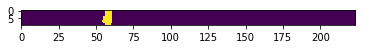

left_orphan: 57
before None check 57, j=0, val=None
before None check 57, j=1, val=None
before None check 57, j=2, val=75
after None check 57
second if 57
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175,

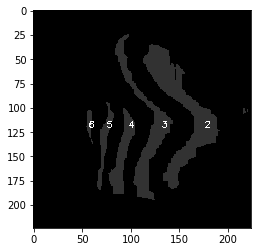

mid_new length: 6
middle sections collapsed (debug):


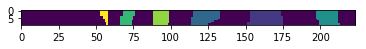

ORPHAN LEN 1, FAM LEN 5
counter 105


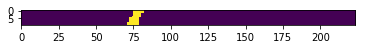

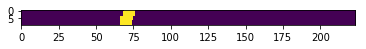

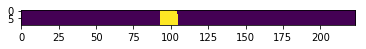

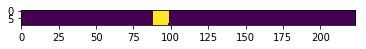

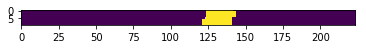

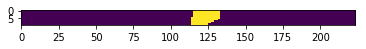

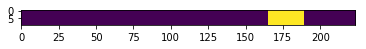

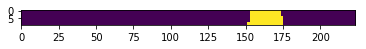

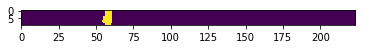

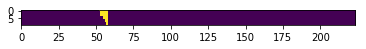

orphan #0


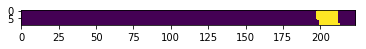

right_orphan: 204
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 1

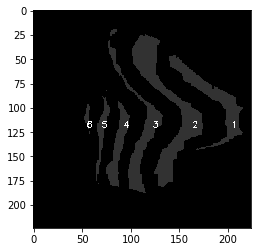

mid_new length: 6
middle sections collapsed (debug):


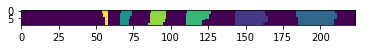

ORPHAN LEN 1, FAM LEN 6
counter 106


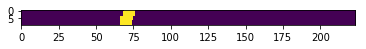

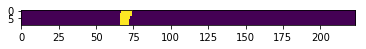

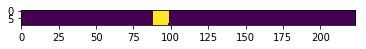

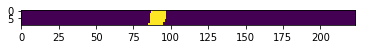

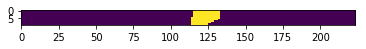

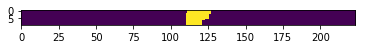

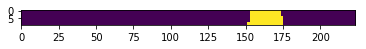

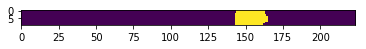

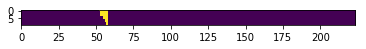

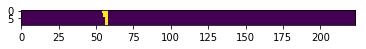

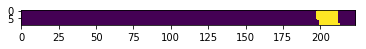

5 NO CHILD!!!
orphan #0


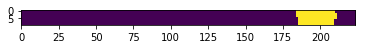

right_orphan: 196
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163, 153], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 14

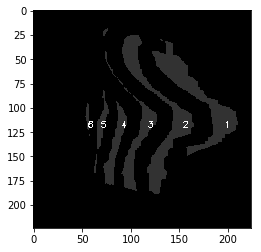

mid_new length: 6
middle sections collapsed (debug):


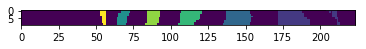

ORPHAN LEN 0, FAM LEN 6
counter 107


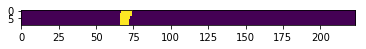

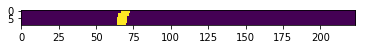

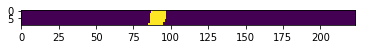

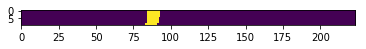

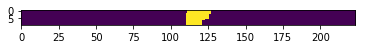

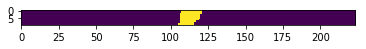

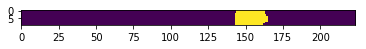

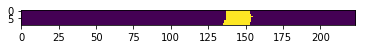

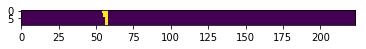

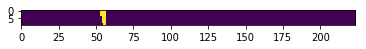

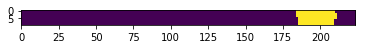

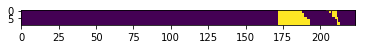

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163, 153, 144], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90, 87], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 1

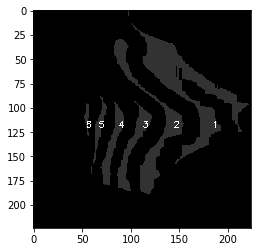

mid_new length: 7
middle sections collapsed (debug):


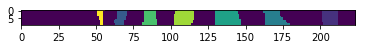

ORPHAN LEN 0, FAM LEN 6
counter 108


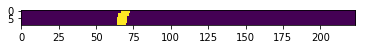

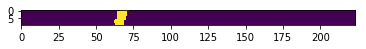

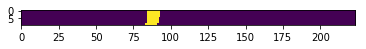

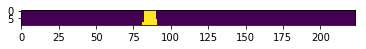

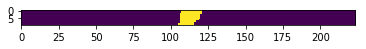

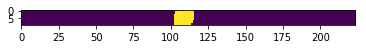

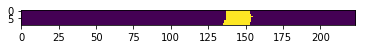

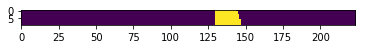

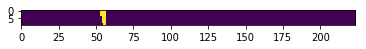

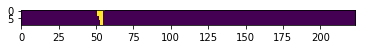

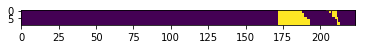

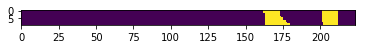

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163, 153, 144, 137], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112, 108], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90, 87, 85], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 14

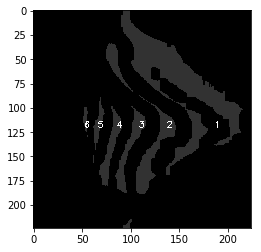

mid_new length: 7
middle sections collapsed (debug):


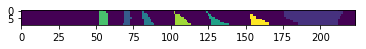

ORPHAN LEN 1, FAM LEN 6
counter 109


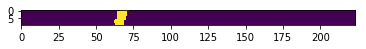

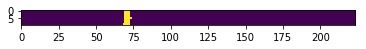

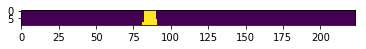

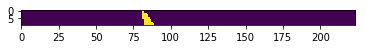

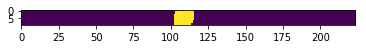

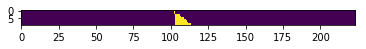

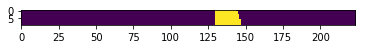

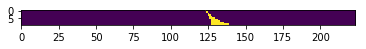

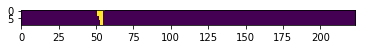

4 NO CHILD!!!


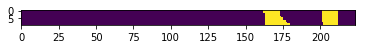

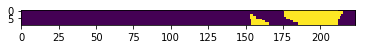

orphan #0


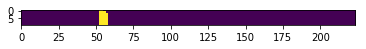

left_orphan: 54
before None check 54, j=0, val=None
before None check 54, j=1, val=None
before None check 54, j=2, val=70
after None check 54
second if 54
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163, 153, 144, 137, 129], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112, 108, 106], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117,

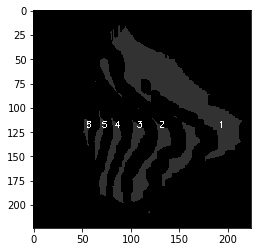

mid_new length: 7
middle sections collapsed (debug):


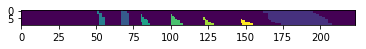

ORPHAN LEN 0, FAM LEN 6
counter 110


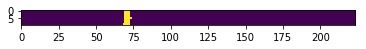

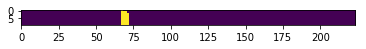

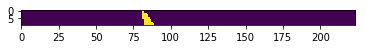

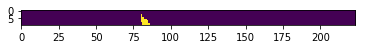

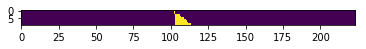

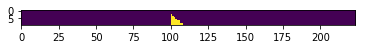

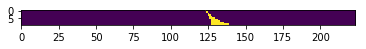

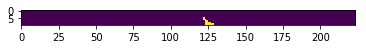

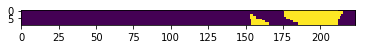

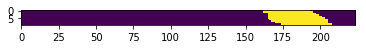

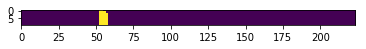

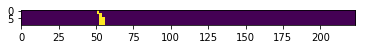

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183], [142, 149, 151, 155, 161, 164, 170, 172, 177, 181, 183, 188, 193, 198, 202, 203, 206, 208, 209, 209, None, 206, None, 202, None, 189, 176, 163, 153, 144, 137, 129, 124], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112, 108, 106, 102], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90, 87, 85, 83, 81], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166,

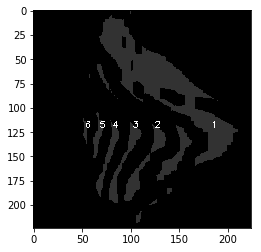

mid_new length: 6
middle sections collapsed (debug):


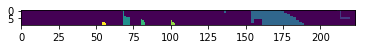

ORPHAN LEN 0, FAM LEN 6
counter 111


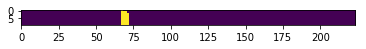

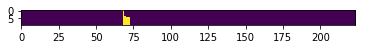

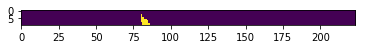

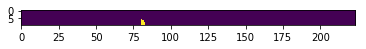

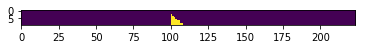

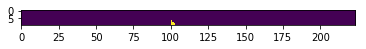

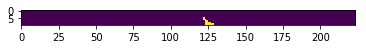

3 NO CHILD!!!


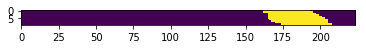

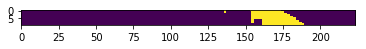

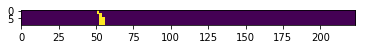

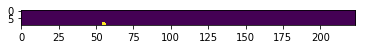

[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112, 108, 106, 102, 100], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90, 87, 85, 83, 81, 80], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135,

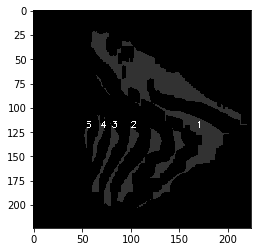

mid_new length: 6
middle sections collapsed (debug):


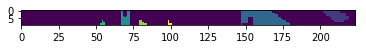

ORPHAN LEN 1, FAM LEN 5
counter 112


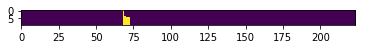

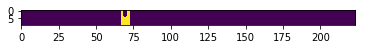

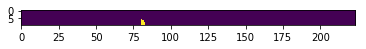

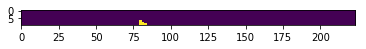

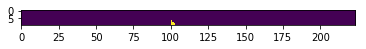

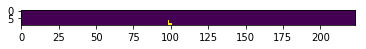

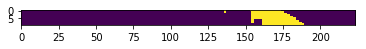

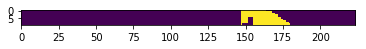

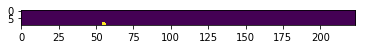

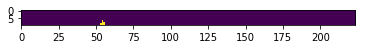

orphan #0


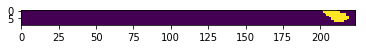

right_orphan: 210
[[213, 212, 212, None, 210], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160], [110, 116, 117, 121, 125, 127, 130, 132, 135, 137, 138, 141, 144, 147, 148, 149, 155, 159, 163, 166, 168, 170, 176, 178, 185, 188, 191, 194, 195, 201, 207, 209, 208, None, 202, None, 199, 192, 186, 166, 155, 146, 134, 132, 122, 117, 112, 108, 106, 102, 100, 98], [86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 209, 212, 214, 216, 216, None, 212, None, 186, None, 205, None, 197, 176, 174, 169, 165, 157, 150, 146, 139, 133, 127, 117, 112, 107, 100, 98, 93, 90, 87, 85, 83, 81, 80, 80], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149

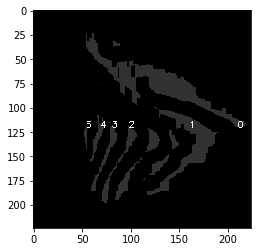

mid_new length: 7
middle sections collapsed (debug):


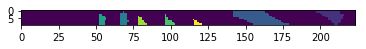

ORPHAN LEN 0, FAM LEN 6
counter 113


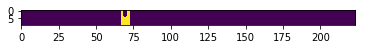

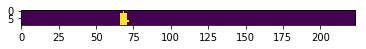

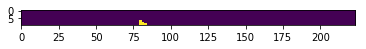

1 NO CHILD!!!


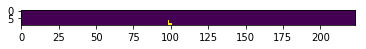

2 NO CHILD!!!


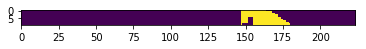

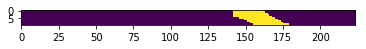

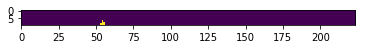

4 NO CHILD!!!


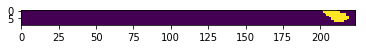

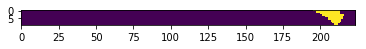

[[213, 212, 212, None, 210, 207], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160, 157], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87, 86, 82, 81, 79, 73, 75, 70, 69, 67, 66, 70, 68, 69, 69, 68], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91, 91, 90, 94, 102, 102, 102, 101, 97, 93, 96, 95, 94, 96, None, 92, 95, 101, 102, 102, 101, 102, 103, 102, 100, 98, 95, 98, 96, 94, 91, None, 82, None, 73, 71, None, 66, 65, 63, 64, 66, 64, 62, None, 57, 55, 56, 54, 52, None, 5

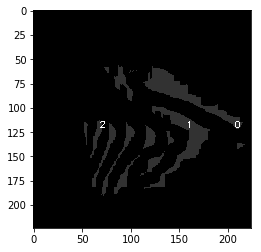

mid_new length: 8
middle sections collapsed (debug):


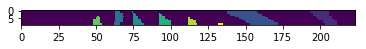

ORPHAN LEN 0, FAM LEN 3
counter 114


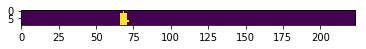

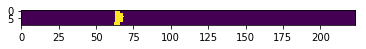

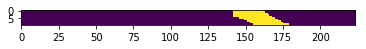

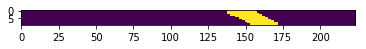

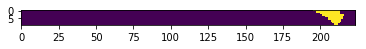

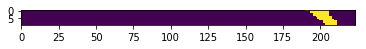

[[213, 212, 212, None, 210, 207, 201], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160, 157, 153], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87, 86, 82, 81, 79, 73, 75, 70, 69, 67, 66, 70, 68, 69, 69, 68, 64], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91, 91, 90, 94, 102, 102, 102, 101, 97, 93, 96, 95, 94, 96, None, 92, 95, 101, 102, 102, 101, 102, 103, 102, 100, 98, 95, 98, 96, 94, 91, None, 82, None, 73, 71, None, 66, 65, 63, 64, 66, 64, 62, None, 57, 55, 56, 5

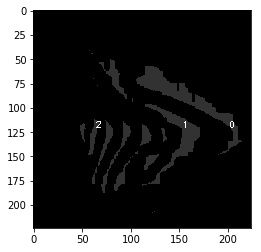

mid_new length: 7
middle sections collapsed (debug):


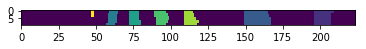

ORPHAN LEN 3, FAM LEN 3
counter 115


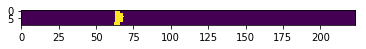

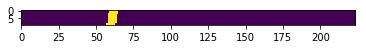

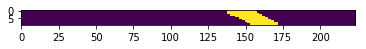

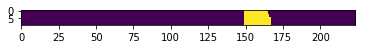

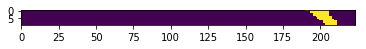

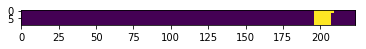

orphan #0


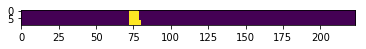

orphan #1


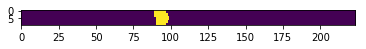

orphan #2


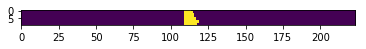

MIDDLE BLOB BEING INSERTED cX: 75
MIDDLE BLOB BEING INSERTED cX: 93
MIDDLE BLOB BEING INSERTED cX: 112
[[213, 212, 212, None, 210, 207, 201, 201], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160, 157, 153, 157], [112], [93], [75], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87, 86, 82, 81, 79, 73, 75, 70, 69, 67, 66, 70, 68, 69, 69, 68, 64, 60], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91, 91, 90, 94, 102, 102, 102, 101, 97, 93, 96, 95, 94, 96, None, 92, 95, 101, 

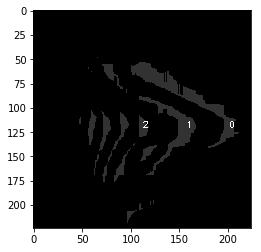

mid_new length: 7
middle sections collapsed (debug):


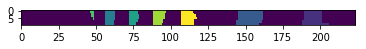

ORPHAN LEN 0, FAM LEN 6
counter 116


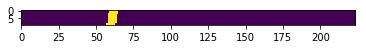

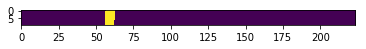

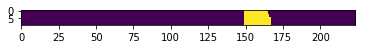

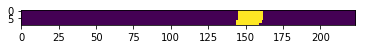

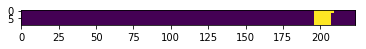

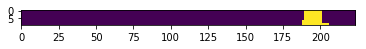

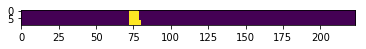

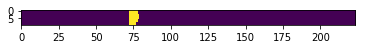

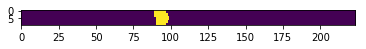

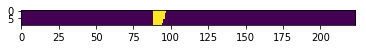

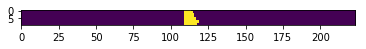

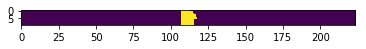

[[213, 212, 212, None, 210, 207, 201, 201, 194], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160, 157, 153, 157, 152], [112, 111], [93, 91], [75, 74], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87, 86, 82, 81, 79, 73, 75, 70, 69, 67, 66, 70, 68, 69, 69, 68, 64, 60, 58], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91, 91, 90, 94, 102, 102, 102, 101, 97, 93, 96, 95, 94, 96, None, 92, 95, 101, 102, 102, 101, 102, 103, 102, 100, 98, 95, 98, 96, 94, 91, None, 82, None, 7

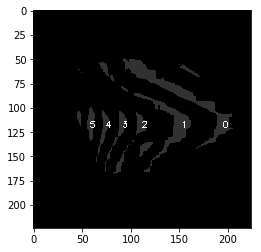

mid_new length: 2
middle sections collapsed (debug):


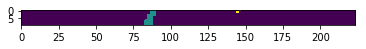

ORPHAN LEN 0, FAM LEN 6
counter 117


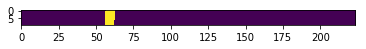

0 NO CHILD!!!


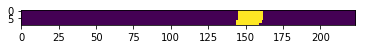

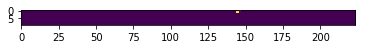

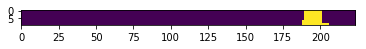

2 NO CHILD!!!


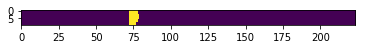

3 NO CHILD!!!


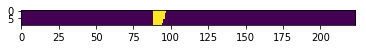

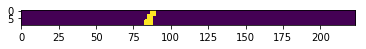

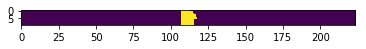

5 NO CHILD!!!
[[213, 212, 212, None, 210, 207, 201, 201, 194, None], [176, 187, 191, 199, 206, 209, 212, 213, 216, 217, None, 204, None, 196, 184, 186, 190, 183, 168, 160, 157, 153, 157, 152, 145], [93, 91, 85], [75, 74, None], [141, 146, 151, 155, 155, 162, 165, 174, 178, 179, 178, 175, 170, 170, 167, 169, 166, 164, 166, 164, 158, 159, 153, 154, 152, 148, 143, 144, 144, 143, 142, None, 143, 139, 136, 136, 134, 134, 136, 141, 146, 148, 149, 154, 161, 161, 161, 159, 151, 135, 131, 125, 121, 116, 107, 99, 96, 94, 91, 87, 86, 82, 81, 79, 73, 75, 70, 69, 67, 66, 70, 68, 69, 69, 68, 64, 60, 58, None], [53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95, 96, 92, 92, 94, 95, 97, 98, 98, 103, 106, 109, 107, 100, 95, 94, 93, 93, 97, 102, 103, 99, 93, 93, 91, 91, 91, 90, 94, 102, 102, 102, 101, 97, 93, 96, 95, 94, 96, None, 92, 95, 101, 102, 102, 101, 102, 103, 102, 100, 98, 95, 98, 

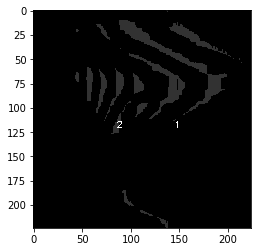

mid_new length: 1
middle sections collapsed (debug):


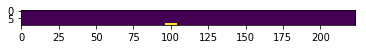

ORPHAN LEN 0, FAM LEN 2
counter 118


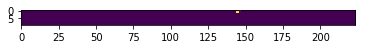

0 NO CHILD!!!


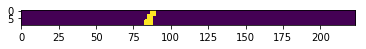

1 NO CHILD!!!
[]


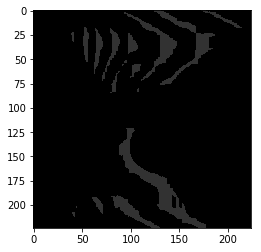

mid_new length: 1
middle sections collapsed (debug):


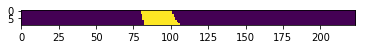

ORPHAN LEN 1, FAM LEN 0
counter 119
orphan #0


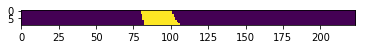

IndexError: list index out of range

In [145]:
## Tracking only the mid sections!

verbose = False

###INIT FOR FIRST FRAME
prev_frame = mask_continuous_timeline[0]==1
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)

mid_blob_tracks = []
for m in blobs_prev:
    if blob_area(m[112:122:])>0:
        M = cv2.moments((m[112:122:]>0).astype(np.uint8))
        cX = int(M["m10"] / M["m00"])
        mid_blob_tracks.append([cX])

mid_blob_tracks.sort(reverse=True)
mid_temp = get_middle_section(blobs_prev, collapse_channels=False)
mid_prev=[]
for mid in mid_temp:
    if blob_area(mid)>0:
        print("area > 0")
        mid_prev.append(mid)

for (i, img) in enumerate(mask_continuous_timeline[2:]):
    img = img==1
    
    #Find all blobs in current frame
    blobs_current = get_blobs_single_class(img, label_value=255)
    mid_temp = get_middle_section(blobs_current, collapse_channels=False)
    mid_new = []
    for mid in mid_temp:
        if blob_area(mid)>0:
            mid_new.append(mid)
    print("mid_new length: {}".format(len(mid_new)))
    
    #DEBUG ONLY
    print("middle sections collapsed (debug):")
    pltimg(get_middle_section(blobs_current, collapse_channels=True))


    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(mid_new, mid_prev, orphan_min_area=50)
    #DEBUG ONLY
    print("ORPHAN LEN {}, FAM LEN {}".format(len(orphans), np.shape(blobs_new)[0]))
    if blobs_new is None:
        print("EMPTY!!")

    #Add orphans to blobs_prev, so they can become parents in the next iteration
    #Note: this happens AFTER children have already found their parents
    mid_prev = []
    for blob_ in blobs_new:
        if blob_area(blob_[0])>0:
            mid_prev.append(blob_[0])
    #debug check
    for en, bl in enumerate(mid_prev):
        if blob_area(bl)<1:
            print("Empty blob at mid_prev[{}]".format(en))
            
    orphan_imgs = [np.array(o[0]).astype(np.uint8) for o in orphans]
    for o in orphan_imgs:
        if blob_area(o)>0:
             mid_prev.append(o)
                
                
#     for blob_ in blobs_new:
#         if blob_area(blob_[0])>0:
#             mid_prev.append(blob_[0])
#     mid_prev = mid_new

#     mid_blob_tracks = []
    print("counter {}".format(i))
    for ctr,m in enumerate(blobs_new):
        pltimg(m[1])
        
        M_prev = cv2.moments((m[1]>0).astype(np.uint8))
        cX_prev = int(M_prev["m10"] / M_prev["m00"])
        last_values = [track[-1] for track in mid_blob_tracks]
        
        if blob_area(m[0])>0: #non-empty child
            pltimg(m[0])
            M = cv2.moments((m[0]>0).astype(np.uint8))
            cX = int(M["m10"] / M["m00"])        
            
            if cX_prev not in last_values:
                raise Exception('Bad correlation. Parent not in list')
                
            mid_blob_tracks[last_values.index(cX_prev)].append(cX)
        else:#child is empty
            print("{} NO CHILD!!!".format(ctr))
            #####WARNING: THERE IS AN ERROR HERE.
            # cX isnt getting added to last_values, and so index(cX_prev) is not a
            # plausible way to find the index. Fix this on Monday
            mid_blob_tracks[last_values.index(cX_prev)].append(None)
        

    
    #Debug only
    for en, o in enumerate(orphans):
        print("orphan #{}".format(en))
        pltimg(o[0])
        
        
    #Insert at beginning (right-most blobs)
    last_values = [track[-1] for track in mid_blob_tracks]
    start_none, end_none = get_non_None_section(last_values)
    right_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) > last_values[start_none])
    
    for cX in right_orphans:
        last_values = [track[-1] for track in mid_blob_tracks]
        print("right_orphan: {}".format(cX))
        for j, val in enumerate(last_values):
            if val is not None:
                if j==0 and cX > mid_blob_tracks[j][-1]:
                    mid_blob_tracks = [[cX]] + mid_blob_tracks
                    break
                elif j!=0 and mid_blob_tracks[j-1][-1] is None and cX > mid_blob_tracks[j][-1]:
                    mid_blob_tracks[j-1].append(cX)
                #break is intentionally outside of elif
                break
                
    #Insert at end (left-most blobs)
    last_values = [track[-1] for track in mid_blob_tracks]
    start_none, end_none = get_non_None_section(last_values)
    left_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[end_none])
    left_orphans.reverse()
    
    for cX in left_orphans:
        print("left_orphan: {}".format(cX))
        last_values = [track[-1] for track in mid_blob_tracks]
        for j, val in enumerate(reversed(last_values)):
            ctr = len(last_values)-1-j
            print("before None check {}, j={}, val={}".format(cX,j,val))
            if val is not None:
                print("after None check {}".format(cX))
                if ctr==len(last_values)-1 and cX < mid_blob_tracks[ctr][-1]: #i.e. last element in un-reversed last_values)
                    mid_blob_tracks = mid_blob_tracks+[[cX]]
                    print("first if {}".format(cX))
                    break

                elif ctr!=len(last_values)-1 and mid_blob_tracks[ctr+1][-1] is None and cX < mid_blob_tracks[ctr][-1]:
                    mid_blob_tracks[ctr+1].append(cX)
                    print("second if {}".format(cX))
                #break is intentionally outside of elif
                break
    
    #Must remove None islands before inserting a centre blob into tracks
    start_none, end_none = get_non_None_section(last_values)
    temp_tracks=[]
    idx_is_none = [val is None for val in [track[-1] for track in mid_blob_tracks][start_none: end_none+1]]
    for j,val in enumerate(idx_is_none):
        if val is False:
            temp_tracks=temp_tracks+[mid_blob_tracks[j+start_none]]
    mid_blob_tracks = mid_blob_tracks[:start_none]+temp_tracks+mid_blob_tracks[end_none+1:]
    
    #Insert at centre (in between other blobs in frame)
    last_values = [track[-1] for track in mid_blob_tracks]
    start_none, end_none = get_non_None_section(last_values)
    centre_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[start_none] and get_centroid_x(o[0]) > last_values[end_none])
    
    import bisect as bi
    for cX in centre_orphans:
        print("MIDDLE BLOB BEING INSERTED cX: {}".format(cX))
        last_values = [track[-1] for track in mid_blob_tracks][start_none: end_none+1]
        #must reverse list for insort to work properly (i.e. insort requires low to hi sorted)
        last_values.reverse()
        bi.insort(last_values, cX)
        last_values.reverse()
        idx = last_values.index(cX)+start_none
        mid_blob_tracks=mid_blob_tracks[:idx]+[[cX]]+mid_blob_tracks[idx:]
        
#     if len(centre_orphans)>0:
#         #Remove None islands caused by middle orphan insertion
#         temp_tracks=[]
#         idx_is_none = [val is None for val in [track[-1] for track in mid_blob_tracks][start_none: end_none+1]]
#         for j,val in enumerate(idx_is_none):
#             if val is False:
#                 temp_tracks=temp_tracks+[mid_blob_tracks[j+start_none]]
#         mid_blob_tracks = mid_blob_tracks[:start_none]+temp_tracks+mid_blob_tracks[end_none:]
    
    
    #######OLD VERSION THAT SORTA WORKS#######
    ##########################################
#     orphan_x = []
#      
#         print("orphan")
#         pltimg(o[0])
#         if blob_area(o[0])>0:
#             M = cv2.moments((o[0]>0).astype(np.uint8))
#             cX = int(M["m10"] / M["m00"])
#             print("orphan cX: {}".format(cX))
#     #         orphan_x.append(cX)
#             last_values = [track[-1] for track in mid_blob_tracks]

#             ######INSERT ORPHAN#####
#             #Find first non-None value
#             for j, val in enumerate(last_values):
#                 if val is not None:
#                     if j==0 and cX > mid_blob_tracks[j][-1]:
#                         mid_blob_tracks = [[cX]] + mid_blob_tracks
#                         break
#                     elif j!=0 and mid_blob_tracks[j-1][-1] is None and cX > mid_blob_tracks[j][-1]:
#                         mid_blob_tracks[j-1].append(cX)
#                     #break is intentionally outside of elif
#                     break
#             #Find last non-None value  
#             #note: when using reversed, enumerated i doesnt reverse
#             for j, val in enumerate(reversed(last_values)):
#                 ctr = len(last_values)-1-j
#                 if val is not None:
#                     if ctr==len(last_values)-1 and cX < mid_blob_tracks[ctr][-1]: #i.e. last element in un-reversed last_values)
#                         mid_blob_tracks = mid_blob_tracks+[[cX]]
#                         break
                        
#                     elif ctr!=len(last_values)-1 and mid_blob_tracks[ctr+1][-1] is None and cX < mid_blob_tracks[ctr][-1]:
#                         mid_blob_tracks[ctr+1].append(cX)
                        
#                     else: #is a blob in the middle
#                         print("")
                    
                        
#                     #break is intentionally outside of elif
#                     break
    #######OLD VERSION THAT SORTA WORKS#######
    ##########################################
    #DEBUG ONLY
    print(mid_blob_tracks)
    
#                     if cX > val: #Entering from right (i.e. trachea up)
#                         #find the first entry that is not None
#                         if i>0 and last_values[i-1] is None:
#                             mid_blob_tracks[i-1].append(cX)
#                     if cX < last_values[-1]:
                            
                    
                    
#             if cX > mid_blob_tracks[0]:
#                 mid_blob_tracks = [ox]+mid_blob_tracks
#             elif cX<mid_blob_x[-1]:
#                 mid_blob_tracks = mid_blob_tracks = [ox]
#             else: #TODO: deal with inserting element in between 2 elements
#                 print("")


#     orphan###########
    
    prev_frame = img
    last_values = [track[-1] for track in mid_blob_tracks]
    cimg = cv2.cvtColor((img*50).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for cX in last_values[start_none: end_none+1]:
        cv2.putText(cimg , "{}".format(last_values.index(cX)), (cX, 120), cv2.FONT_HERSHEY_SIMPLEX,0.3, (255, 255, 255), 1)
    pltimg(cimg)
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
#     print(cnt)
#     time.sleep(0.5)
    
    

In [146]:
last_values, get_non_None_section(last_values)

([], (0, -1))

In [147]:
# len(mid_blob_tracks)
mid_blob_tracks

[]

> <ipython-input-44-8725fc2fc189>(66)correlate_blobs()
     64         for p in range(0,len(prev_blobs)):
     65             pblob = prev_blobs[p]
---> 66             intersect = cv2.bitwise_and(nblob, pblob)
     67 
     68             if blob_area(intersect) > max_intercept:

ipdb> np.shape(mid_new)
(7, 10, 224)
ipdb> np.shape(mid_prev)
(3, 10, 224)
ipdb> pltimg(mid_new[0])


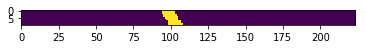

ipdb> pltimg(mid_new[1])


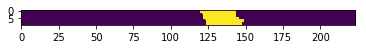

ipdb> pltimg(mid_new[2])


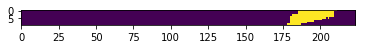

ipdb> pltimg(mid_new[3])


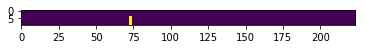

ipdb> pltimg(mid_new[4])


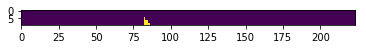

ipdb> pltimg(mid_new[5])


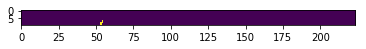

ipdb> pltimg(mid_new[6])


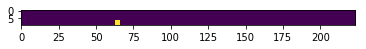

ipdb> pltimg(mid_new[7])
*** IndexError: list index out of range
ipdb> pltimg(mid_prev[0])


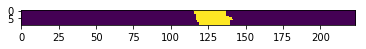

ipdb> pltimg(mid_prev[1])


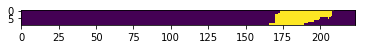

ipdb> pltimg(mid_prev[2])


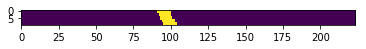

ipdb> pltimg(mid_prev[3])
*** IndexError: list index out of range
ipdb> pltimg(n_blob)
*** NameError: name 'n_blob' is not defined
ipdb> pltimg(nblob)


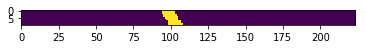

ipdb> pltimg(pblob)


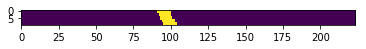

ipdb> nblob.dtype
dtype('uint8')
ipdb> pblob.dtype
dtype('int32')
ipdb> cv2.bitwise_and(nblob,pblob)
*** cv2.error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/core/src/arithm.cpp:223: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8)
*** SyntaxError: unexpected EOF while parsing
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8))
array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)
ipdb> np.unique(cv2.bitwise_and(nblob,pblob.astype(np.uint8)))
array([  0, 255], dtype=uint8)
ipdb>

In [127]:
%debug

In [99]:
# contiguous_regions([False,False,True,True,False,True,False])
l = [False,2,3,False,5,False]
l3 = [1,None,None,4,None,6]
# regs = contiguous_regions(l);regs

l2=[]
for j,val in enumerate(l):
    if val is False:
        l2=l2+[l3[j]]
# for val in l:
#     l2+=[
print(l2)
# l2 = l[0:regs[0][0]]
# for section in regs:
#     l2 = l2+l[section[0]:section[1]]

[1, 4, 6]


In [100]:
[val is None for val in [track[-1] for track in mid_blob_tracks][start_none: end_none+1]]

[False, True, False]

In [103]:
%debug

> <ipython-input-102-1207723cfc30>(51)<listcomp>()
     49         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     50         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 51         last_values = [track[-1] for track in mid_blob_tracks]
     52 
     53         if blob_area(m[0])>0: #non-empty child

ipdb> temp_tracks
[86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133, 134, 53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95]
ipdb> q


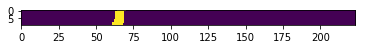

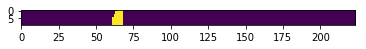

In [142]:
img = img==1
    
#Find all blobs in current frame
blobs_current = get_blobs_single_class(img, label_value=255)
mid_new = get_middle_section(blobs_current, collapse_channels=False)
pltimg(mid_new[5])
    
#Find all blobs in current frame
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
mid_prev = get_middle_section(blobs_prev, collapse_channels=False)
pltimg(mid_prev[4])

n, o = correlate_blobs([mid_new[5]], [mid_prev[4]], orphan_min_area=0)

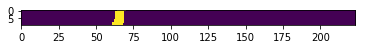

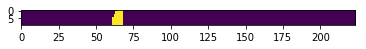

(1, 2, 10, 224)


In [143]:
pltimg(n[0][0])
pltimg(n[0][1])
print(np.shape(n))
# np.shape(mid_prev)

In [109]:
%debug

> <ipython-input-108-c37cb91e9cc4>(50)<listcomp>()
     48         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     49         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 50         last_values = [track[-1] for track in mid_blob_tracks]
     51 
     52         if blob_area(m[0])>0: #non-empty child

ipdb> mid_blob_tracks
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212], [142, 149, 151, 155, 161, 164, 170], [110, 116, 117, 121, 125, 127, 130], [86, 90, 91, 94, 96, 98, 100], [66, 70, 71, 73, 75, 76, 77], [53, 55, 55, 57, 59, 59, 61], 53]
ipdb> q


TypeError: Invalid dimensions for image data

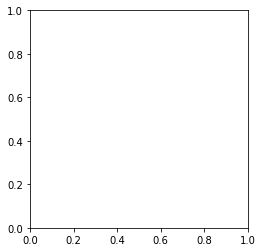

In [66]:
pltimg(mid_new)
pltimg(mid_prev)
# new_blobs, orphans=  correlate_blobs(blobs_prev[3],blobs_prev[3])

In [65]:
%debug

> /opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py(646)set_data()
    644         if not (self._A.ndim == 2
    645                 or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):
--> 646             raise TypeError("Invalid dimensions for image data")
    647 
    648         if self._A.ndim == 3:

ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> q


In [147]:
colours = np.linspace(10,249,40).astype(np.uint8)

# index = random.randint(0,len(colours)-1)
np.random.shuffle(colours)
last = colours[-1]
last

242

/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:386: RuntimeWarning: invalid value encountered in true_divide
  overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colour).astype(np.uint8)


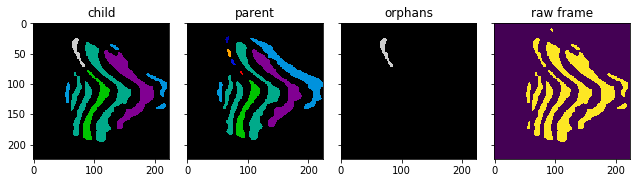

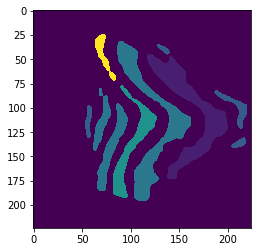

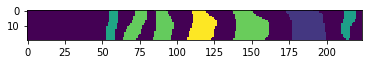

1


/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:388: RuntimeWarning: invalid value encountered in true_divide
  overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colour).astype(np.uint8)


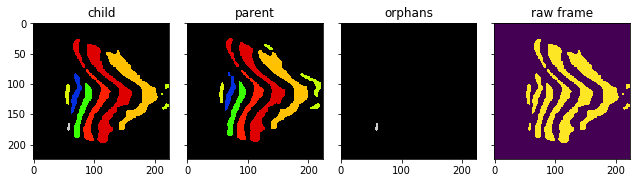

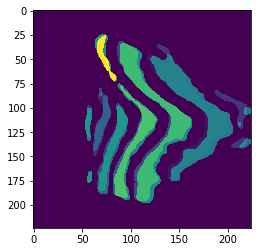

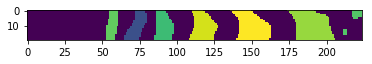

2


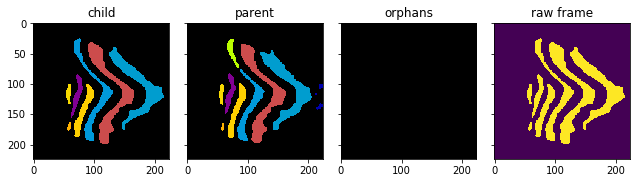

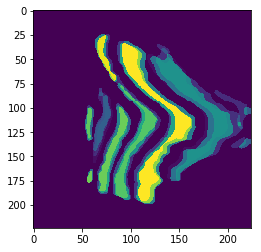

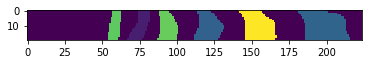

3


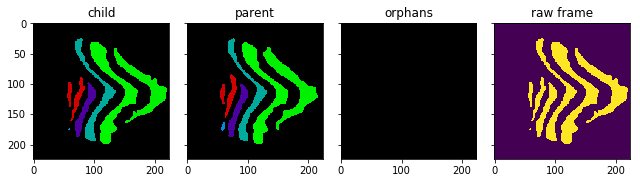

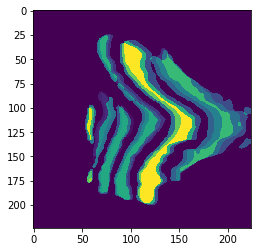

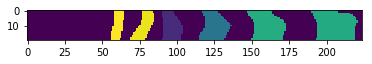

4


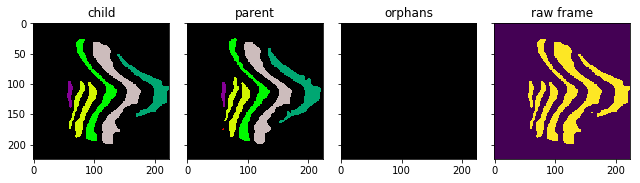

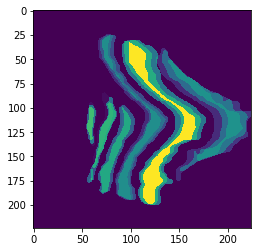

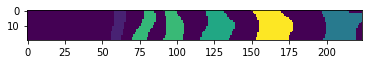

5


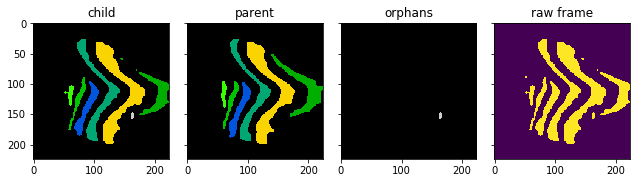

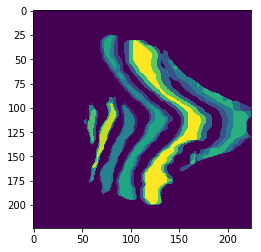

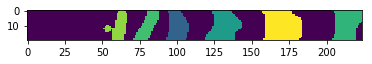

6


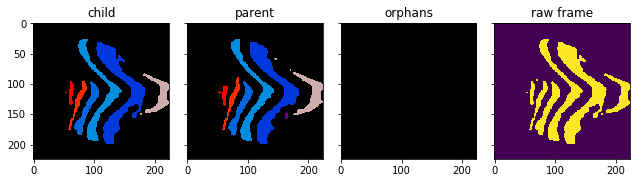

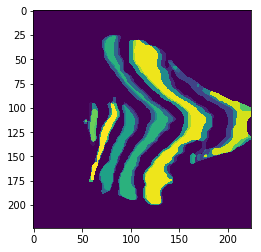

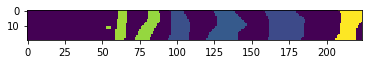

7


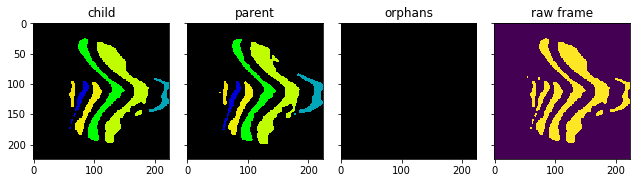

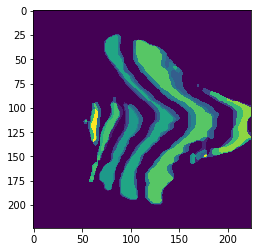

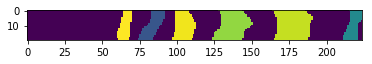

8


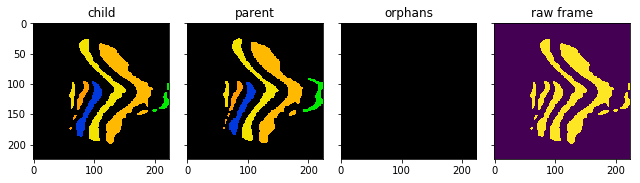

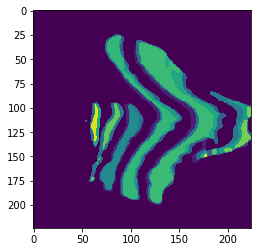

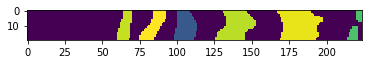

9


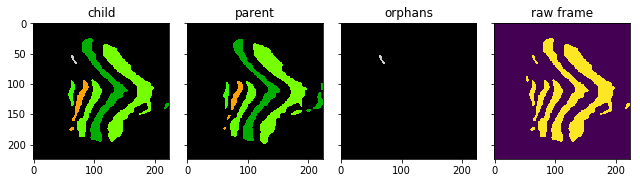

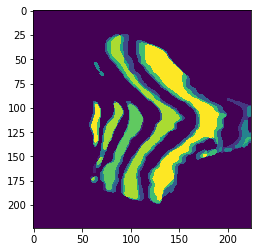

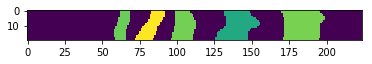

10


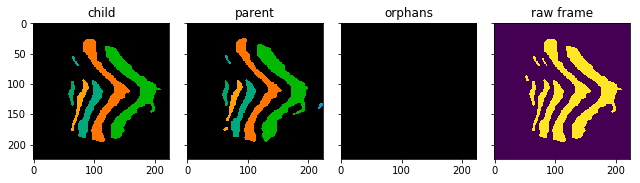

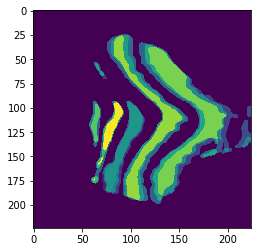

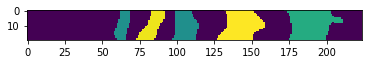

11


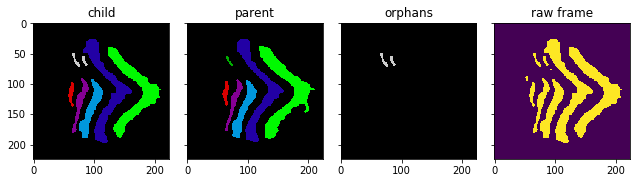

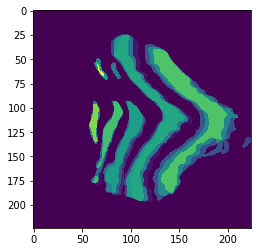

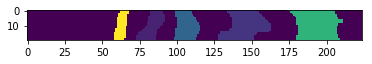

12


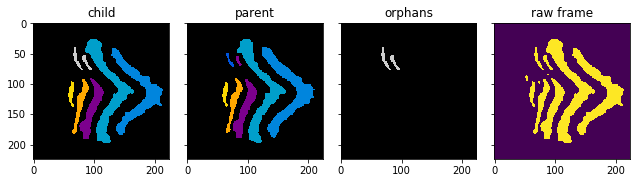

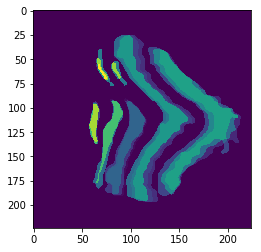

KeyboardInterrupt: 

In [65]:
## TEST ONE!!!

verbose = False
prev_frame = clean_blobs[0]
# prev_frame = avg_frames([mask_continuous_timeline[2],mask_continuous_timeline[1],mask_continuous_timeline[0]])
# prev_frame = clean_blobs[0]==255
# pltimg(prev_frame)
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
cnt = 0

# for img in clean_blobs:
prev_children = [np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0])]
show_overlap = True
for (i, img) in enumerate(clean_blobs[2:]):
#     img = img==1

    #Attempt at averaging stuff
#     img = avg_frames([mask_continuous_timeline[i-2],mask_continuous_timeline[i-1],mask_continuous_timeline[i]])
#     pltimg(img)
#     pltimg(prev_frame)

#     clear_output(wait=True)
#     print("counter: {}".format(cnt))
    cnt +=1
    
    #Find blobs
    blobs_current = get_blobs_single_class(img, label_value=255)
#     blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
    
    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(blobs_current, blobs_prev)
    
    if blobs_new is None:
        print("EMPTY!!")
#     print("blobs_new shape {}".format(np.shape(blobs_new)))
#     test_img = (blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8) | (np.zeros_like(blobs_new[0][0]))
#     pltimg(blobs_new[cnt-1][0])
#     print("done test {}   {}".format(np.unique((blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8)), np.unique(test_img)))
    
    #######WRONG! Cant just re-find blobs!!!! ...but it works.......
    #Collapse all new blobs into a single frame to make it "prev_frame" for the next iteration
#     blobs_new_frame = collapse_all_channels(blobs_new)   
#     blobs_prev = get_blobs_single_class(blobs_new_frame, label_value=255)
    
    #Add orphans to blobs_prev, so they can become parents in the next iteration
    #Note: this happens AFTER children have already found their parents
    blobs_prev = [blob_[0] for blob_ in blobs_new]
    orphan_imgs = [np.array(o[0]).astype(np.int32) for o in orphans]
    blobs_prev = blobs_prev+orphan_imgs
    
#     pltimg(img)
    children = plot_blob_generations(blobs_new, orphans, include_orphans=True, frame=img)
    
    if show_overlap: #Shows overlap of the past 3 frames. Good way of judging how difficult tracking will be
        prev_children[cnt%3] = children
        pltimg(prev_children[0]+prev_children[1]+prev_children[2])#   ---   (prev_children[cnt%3]+children)/np.max(prev_children[cnt%3]+children)
        pltimg(children[102:122,:])
#     if cnt ==5:
#         break
    
    prev_frame = img
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
    print(cnt)
#     time.sleep(0.5)
    
    